# 2: First look at data

In this lesson we will look at a toy dataset simulating $J/\psi \rightarrow \mu^+ \mu^-$ events. We will discuss ways of loading the data in python,
data formats and plotting with ```matplotlib``` and [mplhep](https://mplhep.readthedocs.io/en/latest/index.html).

### Two plotting libraries?
While ```matplotlib``` is a general Python library, the latter is a [Scikit-HEP](https://scikit-hep.org/) package. Scikit-HEP is an organisation which collects, improves and maintains Python packages that are still general, yet
 cover (often rather special) use cases in High Energy Physics. ```mplhep``` as an example provides plotting functionality  and styles to mimic typical plots that you see in HEP. However, it's built completely
 on top of matplotlib and the same can be achieved with pure matplotlib (but more cumbersome). Another example is uproot that we will use to read ROOT files.

### Recap: Importing modules

It's generally seen as good practice to put imports at the top of your file:

In [1]:
import mplhep
import numpy as np
import uproot
from matplotlib import pyplot as plt

## 5. The toy dataset

We're going to look at some fake $J/\psi \rightarrow \mu^+ \mu^-$ data, the variables available are:

- `Jpsi_M` `Jpsi_P` `Jpsi_PT` `Jpsi_PE` `Jpsi_PX` `Jpsi_PY` `Jpsi_PZ`
- `mum_M` `mum_PT` `mum_eta` `mum_PE` `mum_PX` `mum_PY` `mum_PZ` `mum_IP` `mum_ProbNNmu` `mum_ProbNNpi`
- `mup_M` `mup_PT` `mup_eta` `mup_PE` `mup_PX` `mup_PY` `mup_PZ` `mup_IP` `mup_ProbNNmu` `mup_ProbNNpi`
- `nTracks`

The meaning of the suffixes are as follows:

- `_M`: Invariant mass of the particle (fixed to the PDG value for muons)
- `_P`: Absolute value of the particle's three momentum
- `_PT`: Absolute value of the particle's momentum in the `x`-`y` plane
- `_PE`, `_PX`, `_PY`, `_PZ`: Four momentum component of the particle
- `_IP`: Impact parameter, i.e. the distance of closest approach between the reconstructed particle and the primary vertex
- `ProbNNmu`, `ProbNNpi`: Particle identification variables which correspond to how likely it is that the particle is a muon or a pion
- `nTracks`: The total number of tracks in the event

### Loading data

 - `uproot` is a way of reading ROOT files without having ROOT installed, see the github reposity [here](https://github.com/scikit-hep/uproot)
 - We can look at the objects that are available in the file and access objects using dictionary style syntax
 - The tree class contains converters to a variety of common Python libraries, such as numpy
 - We will also use `pandas DataFrames` to load data in a table like format
 (- `root_numpy` and `root_pandas` are an alternative, yet outdated, way of reading+writing ROOT files)

First let's load the data using `uproot`.

Often it is convenient to access data stored on the *grid* at CERN, so you don't have to keep it locally. This can be done using the *XRootD* protocol:

```python
my_file = uproot.open('root://eosuser.cern.ch//eos/user/l/lhcbsk/advanced-python/data/real_data.root')
```
or even better

```python
with uproot.open('root://eosuser.cern.ch//eos/user/l/lhcbsk/advanced-python/data/real_data.root') as my_file:
   ...  # do something here with my_file
```

Accessing data this way requires you to have valid CERN credentials to access it. If authentication fails you will see an error message like:

```
OSError: [ERROR] Server responded with an error: [3010] Unable to give access - user access restricted - unauthorized identity used ; Permission denied
```

Credentials can be obtained by typing `kinit username@CERN.CH` in your terminal and entering your CERN password.

For this tutorial we will use a publicly accessible file instead, using HTTPS to access it remotely. This is significantly slower than using XRootD.

In [2]:
my_file = uproot.open('https://cern.ch/starterkit/data/advanced-python-2018/real_data.root',
                      httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64})

my_file.keys()

['DecayTree;2', 'DecayTree;1']

In order to get a single variable, we can use the indexing. The `array` convert

In [3]:
tree = my_file['DecayTree']
# Get a numpy array containing the J/Ψ mass
tree['Jpsi_M'].array(library='np')

array([3.101106  , 3.1071159 , 3.08600438, ..., 3.00478927, 2.77311478,
       2.7698744 ])

In [4]:
# Load data as a pandas DataFrame
data_df = tree.arrays(library='pd')
my_file.close()  # usually, it's better to open the file with a "with" statement -> needs no closing

# Show the first 5 lines of the DataFrame
data_df.head()

,Jpsi_PE,Jpsi_PX,Jpsi_PY,Jpsi_PZ,Jpsi_PT,Jpsi_P,Jpsi_M,mum_PT,mum_PX,mum_PY,...,mup_PZ,mup_IP,mup_eta,mup_M,mup_PE,nTracks,mum_ProbNNmu,mum_ProbNNpi,mup_ProbNNmu,mup_ProbNNpi
0,188.630181,-1.700534,-9.131937,188.375806,9.288923,188.604688,3.101106,4.376341,-2.246101,-3.755981,...,99.674146,119.018213,3.608728,0.105658,99.820565,149.0,0.999983,0.836058,0.999994,0.244674
1,52.385685,1.816164,5.595537,51.961499,5.882897,52.293459,3.107116,1.735741,1.552217,0.776801,...,41.621295,210.293355,2.851094,0.105658,41.900278,125.0,0.998874,0.264369,0.999999,0.391294
2,52.068478,2.552368,2.817129,51.837748,3.801420,51.976946,3.086004,1.110952,0.179505,1.096355,...,20.279673,38.272015,2.632559,0.105658,20.490677,371.0,0.538509,0.313881,0.882305,0.961390
3,78.399724,-2.833082,-0.818953,78.283360,2.949075,78.338889,3.087923,2.571993,-2.028028,-1.581850,...,9.020064,134.767864,2.792800,0.105658,9.088611,136.0,0.896250,0.792830,0.999992,0.724581
4,83.900727,-5.065507,-3.457333,83.618226,6.132904,83.842831,3.116368,3.698279,-3.220143,-1.818777,...,16.851730,2926.081975,2.619576,0.105658,17.031800,71.0,0.998548,0.270670,0.999987,0.921856


In [5]:
data_df.columns

Index(['Jpsi_PE', 'Jpsi_PX', 'Jpsi_PY', 'Jpsi_PZ', 'Jpsi_PT', 'Jpsi_P',
       'Jpsi_M', 'mum_PT', 'mum_PX', 'mum_PY', 'mum_PZ', 'mum_IP', 'mum_eta',
       'mum_M', 'mum_PE', 'mup_PT', 'mup_PX', 'mup_PY', 'mup_PZ', 'mup_IP',
       'mup_eta', 'mup_M', 'mup_PE', 'nTracks', 'mum_ProbNNmu', 'mum_ProbNNpi',
       'mup_ProbNNmu', 'mup_ProbNNpi'],
      dtype='object')

## 6. Plotting a simple histogram



Text(0.5, 0, 'Jpsi mass')

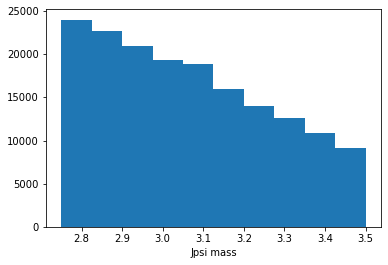

In [6]:
# Start with a basic histogram
plt.hist(data_df['Jpsi_M'])
plt.xlabel('Jpsi mass')

That's okay but we could improve it.

Matplotlib
 - https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html
 - Internally it calls `np.histogram` and  returns an array of counts, an array of bins (as `np.histogram` does) and an array of patches.
 - We can use `histtype="step"` so we can plot multiple datasets on the same axis easily

However, this leaves us with a few things:
 - what if we have our data already as a histogram?
 - We usually want to have uncertainties on the histogram
 - It should match rather the usual style of plots

That's where ```mplhep``` comes into play!

In [7]:
# One of the features of mplhep is that we can set an experiment specific style

plt.style.use(mplhep.style.LHCb2)  # or ATLAS/CMS

Text(1, 0, 'Jpsi mass')

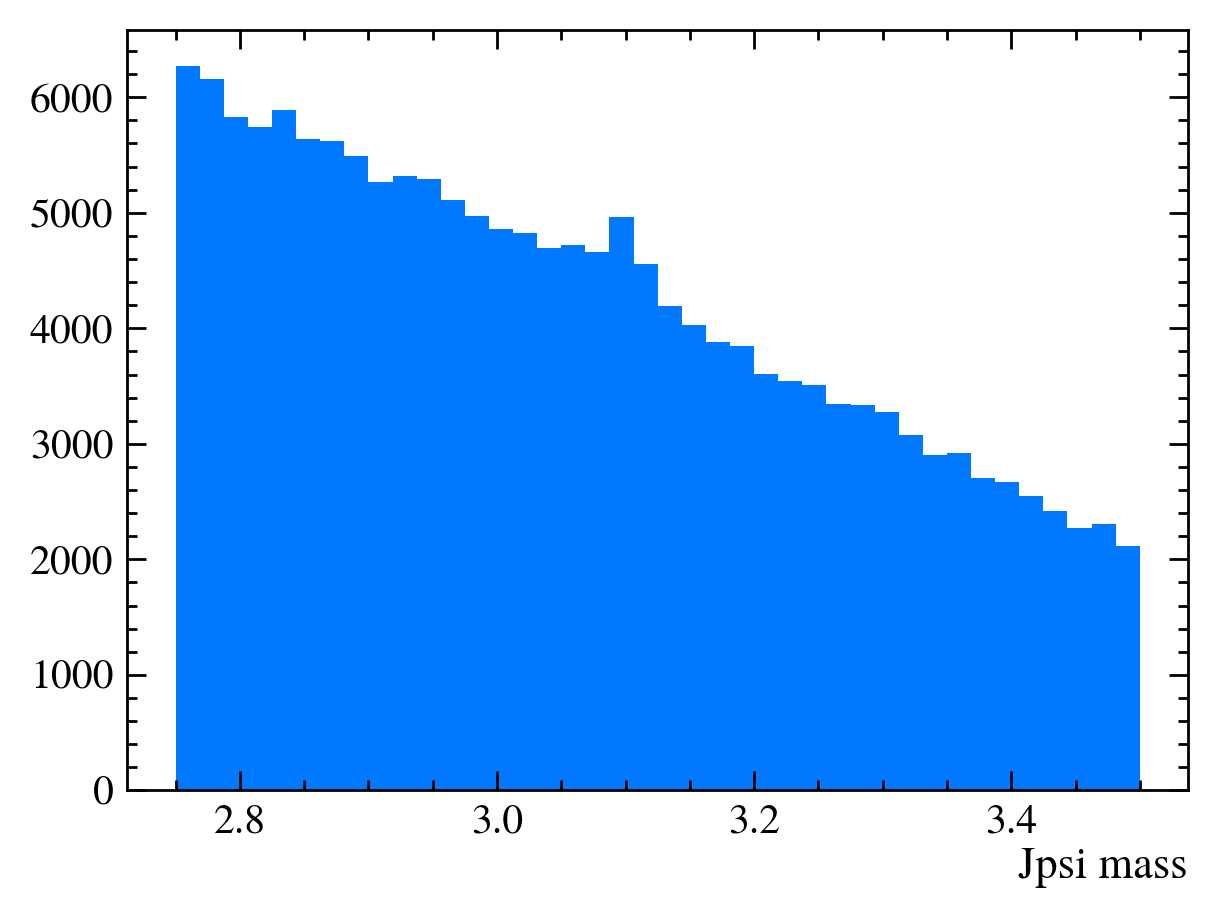

In [8]:
# plotting again
plt.hist(data_df['Jpsi_M'], bins=40)
plt.xlabel('Jpsi mass')

Text(1, 0, 'Jpsi mass')

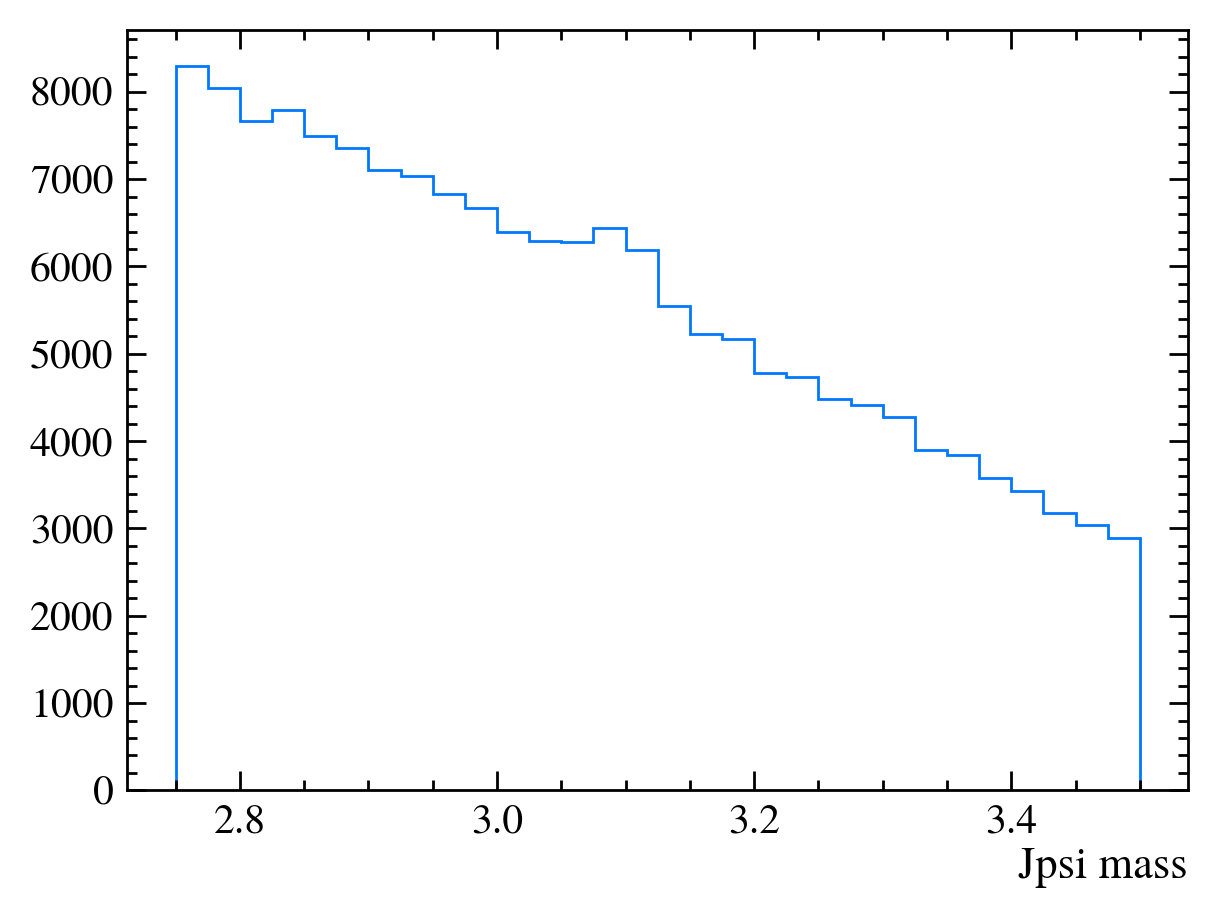

In [9]:
# And similar with mplhep
mplhep.histplot(*np.histogram(data_df['Jpsi_M'], bins=30))
plt.xlabel('Jpsi mass')

[ErrorBarArtists(errorbar=<ErrorbarContainer object of 3 artists>)]

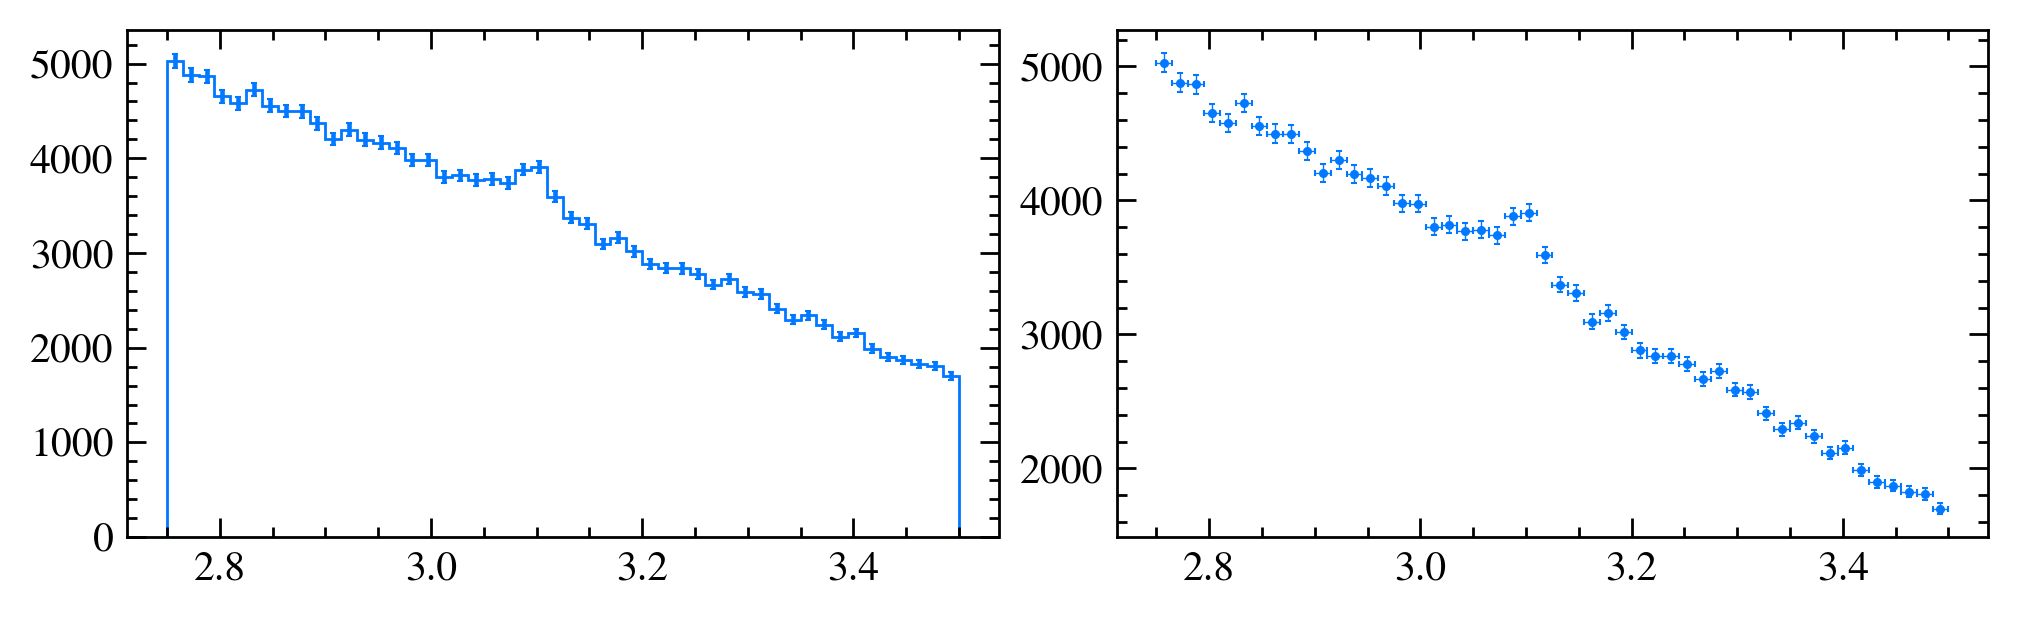

In [10]:
# ... except that it can do a lot more!

# we need to histogram only once!
h, bins = np.histogram(data_df['Jpsi_M'], bins=50)  # TRY OUT: change the binning
plt.subplots(1,2,figsize=(20, 6))
plt.subplot(1, 2, 1)
mplhep.histplot(h, bins, yerr=True)  # error can also be array
plt.subplot(1, 2, 2)
half_binwidths = (bins[1] - bins[0]) / 2
mplhep.histplot(h, bins, histtype='errorbar', yerr=True, xerr=half_binwidths)

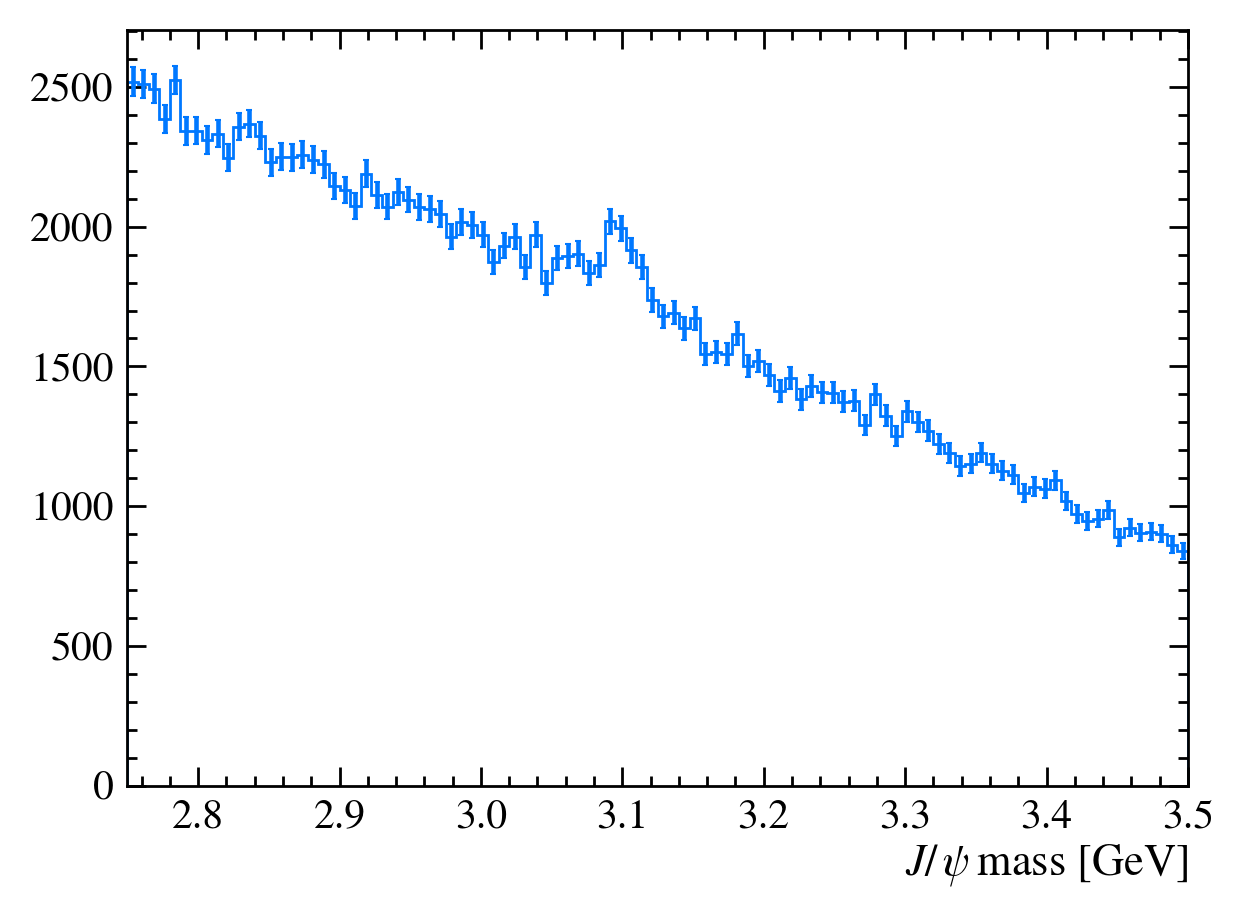

In [11]:
def plot_mass(df):
    h, bins = np.histogram(df['Jpsi_M'], bins=100, range=[2.75, 3.5])
    mplhep.histplot(h, bins, yerr=True)  # feel free to adjust
    # You can also use LaTeX in the axis label
    plt.xlabel('$J/\\psi$ mass [GeV]')
    plt.xlim(bins[0], bins[-1])

plot_mass(data_df)

### Adding variables

In [12]:
# When making the ROOT file we forgot to add some variables, no bother lets add them now!
data_df.eval('Jpsi_eta = arctanh(Jpsi_PZ/Jpsi_P)', inplace=True)
data_df.head()['Jpsi_eta']

0    3.703371
1    2.874790
2    3.307233
3    3.972345
4    3.307082
Name: Jpsi_eta, dtype: float64

**Exercise:** Add `mu_P` and `mum_P` columns to the DataFrame.

In [13]:
data_df.eval('mup_P = sqrt(mup_PX**2 + mup_PY**2 + mup_PZ**2)', inplace=True)
data_df.eval('mum_P = sqrt(mum_PX**2 + mum_PY**2 + mum_PZ**2)', inplace=True)
# We can also get multiple columns at the same time
data_df.head()[['mum_P', 'mup_P']]

,mum_P,mup_P
0,88.809553,99.820509
1,10.484875,41.900145
2,31.577624,20.490405
3,69.311033,9.087997
4,66.868844,17.031472


## Using rectangular cuts

* We want to increase the 'signal significance' of our sample - this means more signal events with respect to background
* To do this we can cut on certain discriminating variables
* Here we will make cuts on the `Jpsi_PT` and **PID** (Particle Identification) variables

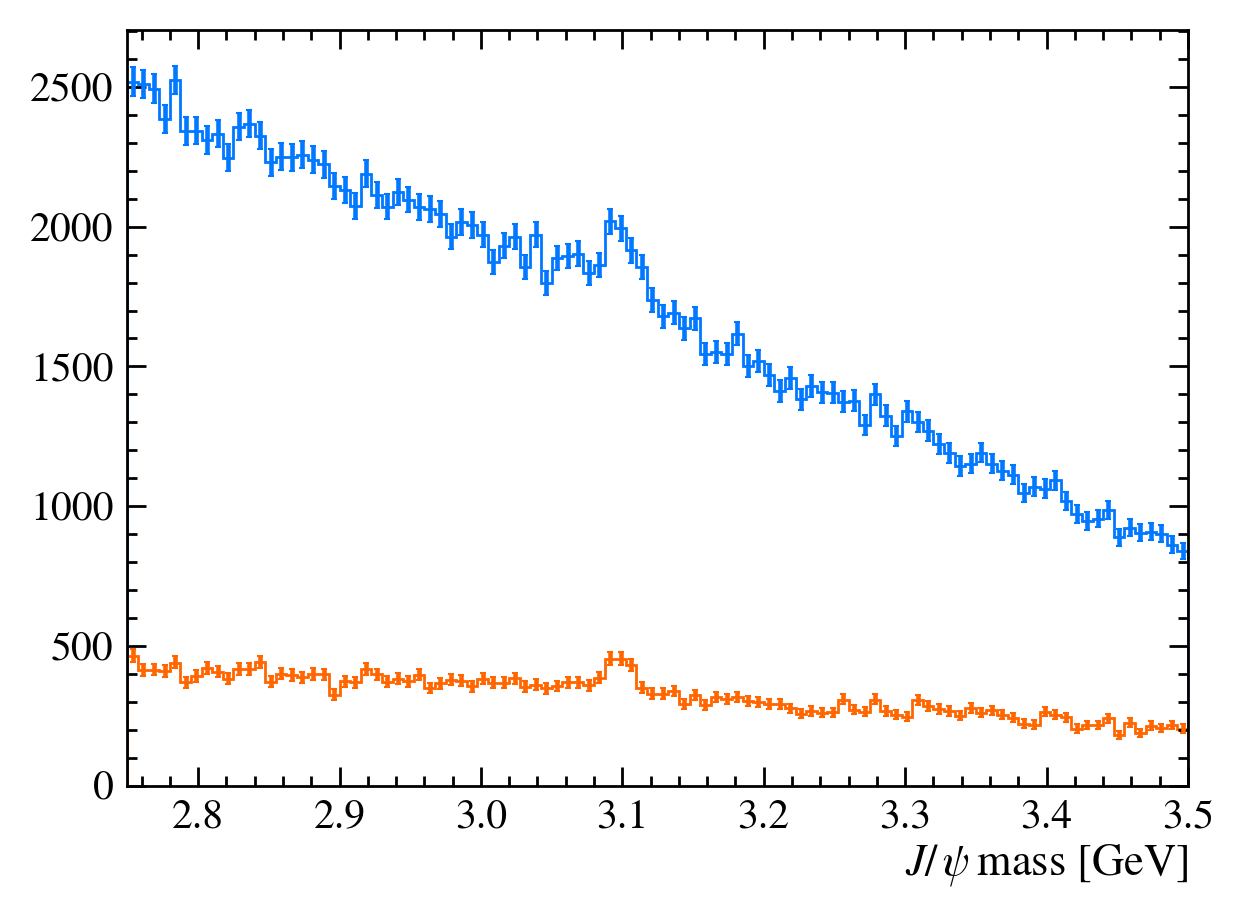

In [14]:
plot_mass(data_df)
data_with_cuts_df = data_df.query('Jpsi_PT > 4')
plot_mass(data_with_cuts_df)

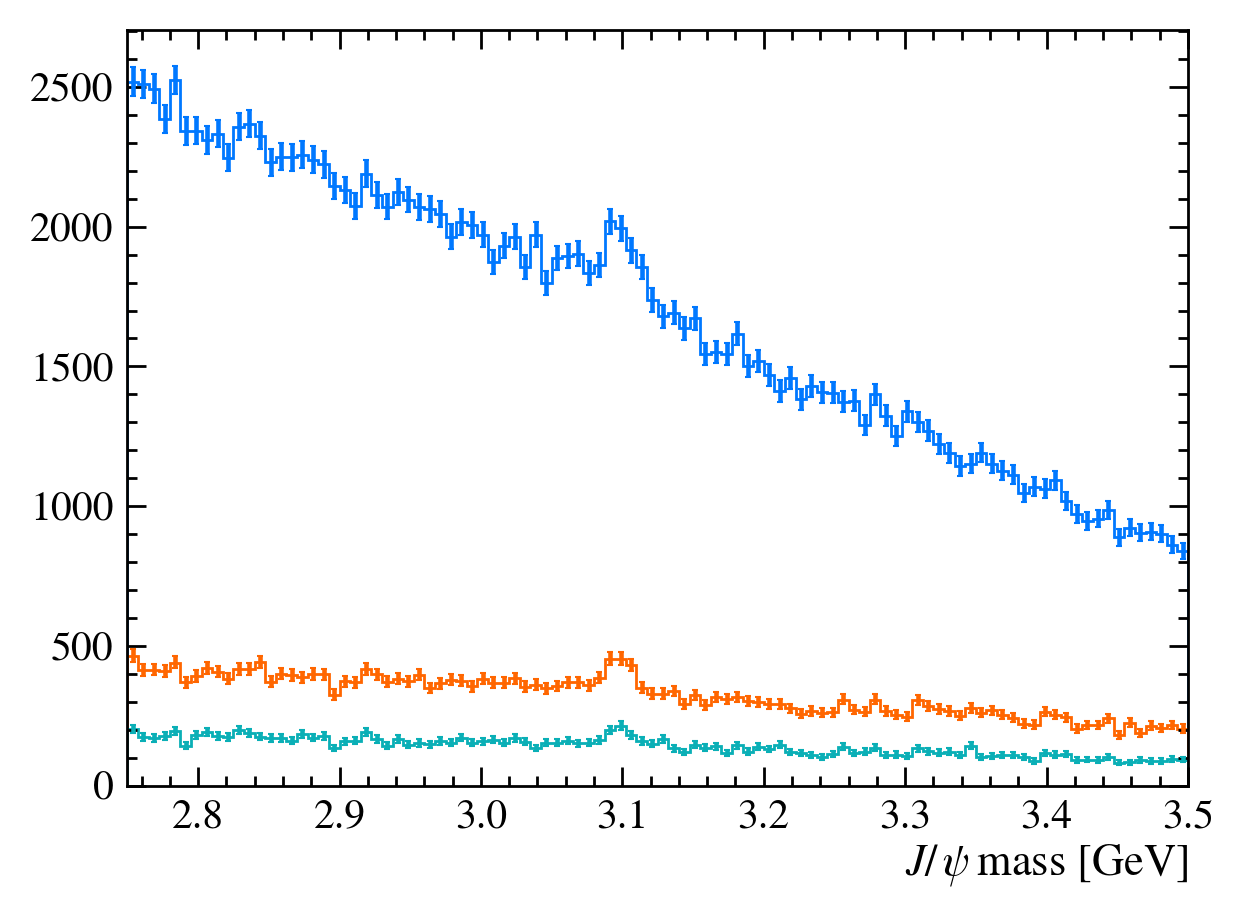

In [15]:
plot_mass(data_df)
data_with_cuts_df = data_df.query('Jpsi_PT > 4')
plot_mass(data_with_cuts_df)
# Lets add some PID cuts as well
data_with_cuts_df = data_df.query('(Jpsi_PT > 4) & ((mum_ProbNNmu > 0.9) & (mup_ProbNNmu > 0.9))')
plot_mass(data_with_cuts_df)

Let's go back and add a label argument to our plot function. This makes it easier to identify each line.
We can also use the `density` argument in `matplotlib.hist` to plot all the histograms as the same scale.

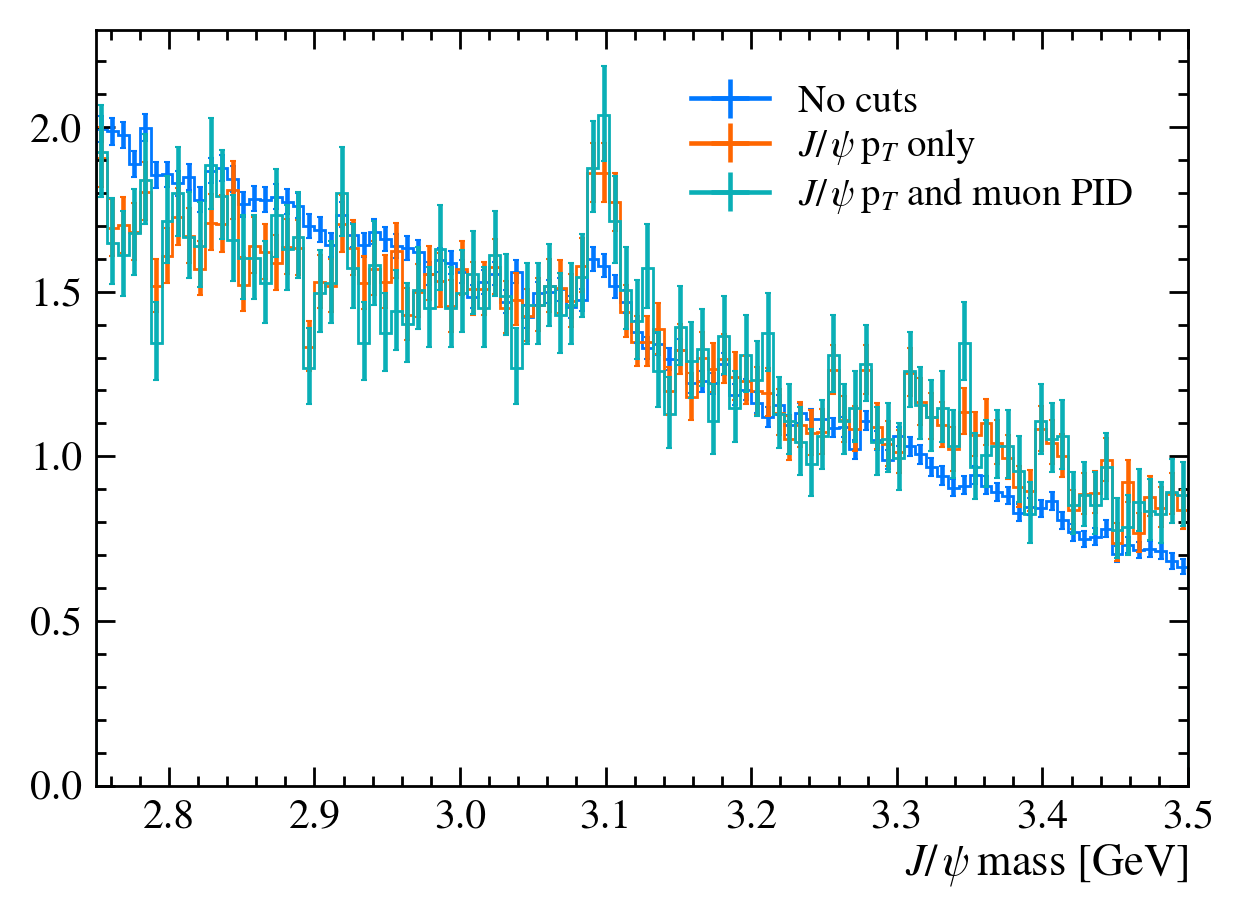

In [16]:
def plot_mass(df, **kwargs):
    h, bins = np.histogram(df['Jpsi_M'], bins=100, range=[2.75, 3.5])
    mplhep.histplot(h, bins, yerr=True, **kwargs)  # feel free to adjust
    # You can also use LaTeX in the axis label
    plt.xlabel('$J/\\psi$ mass [GeV]')
    plt.xlim(bins[0], bins[-1])

plot_mass(data_df, label='No cuts', density=1)
data_with_cuts_df = data_df.query('Jpsi_PT > 4')
plot_mass(data_with_cuts_df, label='$J/\\psi$ p$_T$ only', density=1)
data_with_cuts_df = data_df.query('(Jpsi_PT > 4) & ((mum_ProbNNmu > 0.9) & (mup_ProbNNmu > 0.9))')
plot_mass(data_with_cuts_df, label='$J/\\psi$ p$_T$ and muon PID', density=1)
plt.legend(loc='best')

For this tutorial we have a special function for testing the significance of the signal in our dataset. There are many ways to do this with real data, though we will not cover them here.

In [17]:
data_df.columns

Index(['Jpsi_PE', 'Jpsi_PX', 'Jpsi_PY', 'Jpsi_PZ', 'Jpsi_PT', 'Jpsi_P',
       'Jpsi_M', 'mum_PT', 'mum_PX', 'mum_PY', 'mum_PZ', 'mum_IP', 'mum_eta',
       'mum_M', 'mum_PE', 'mup_PT', 'mup_PX', 'mup_PY', 'mup_PZ', 'mup_IP',
       'mup_eta', 'mup_M', 'mup_PE', 'nTracks', 'mum_ProbNNmu', 'mum_ProbNNpi',
       'mup_ProbNNmu', 'mup_ProbNNpi', 'Jpsi_eta', 'mup_P', 'mum_P'],
      dtype='object')

In [18]:
from python_lesson import check_truth

print('Originally the significance is')
check_truth(data_df)

print('\nCutting on pT gives us')
check_truth(data_df.query('Jpsi_PT > 4'))

print('\nCutting on pT and ProbNNmu gives us')
check_truth(data_df.query('(Jpsi_PT > 4) & ((mum_ProbNNmu > 0.9) & (mup_ProbNNmu > 0.9))'))

Originally the significance is
Loading reference dataset, this will take a moment...


Data contains 1216 signal events
Data contains 167169 background events
Significance metric is 5.58

Cutting on pT gives us
Data contains 602 signal events
Data contains 31922 background events
Significance metric is 6.21

Cutting on pT and ProbNNmu gives us


Data contains 275 signal events
Data contains 13798 background events
Significance metric is 4.31


###  Comparing distributions

Before we just used the cuts that were told to you but how do we pick them?

One way is to get a sample of simulated data, we have a file in `data/simulated_data.root`.

**Exercise:** Load it into a pandas `DataFrame` called `mc_df`. Don't forget to add the `Jpsi_eta`, `mup_P` and `mum_P` columns!

In [19]:
with uproot.open('https://starterkit.web.cern.ch/starterkit/data/advanced-python-2018/simulated_data.root') as mc_file:
    mc_df = mc_file['DecayTree'].arrays(library='pd')

# mc_file = uproot.open('https://starterkit.web.cern.ch/starterkit/data/advanced-python-2018/simulated_data.root')
# mc_df = mc_file['DecayTree'].arrays(library='pd')
mc_df.eval('Jpsi_eta = arctanh(Jpsi_PZ/Jpsi_P)', inplace=True)
mc_df.eval('mup_P = sqrt(mum_PX**2 + mum_PY**2 + mum_PZ**2)', inplace=True)
mc_df.eval('mum_P = sqrt(mum_PX**2 + mum_PY**2 + mum_PZ**2)', inplace=True)

**QUESTION:** What can we to get a background sample?

Sidebands, we know the peak is only present in $3.0~\text{GeV} < M(J/\psi) < 3.2~\text{GeV}$. If we select events outside the region we know it's a pure background sample.

**Exercise:** Make a new `DataFrame` called `bkg_df` containing only events outside $3.0~\text{GeV} < M(J/\psi) < 3.2~\text{GeV}$.

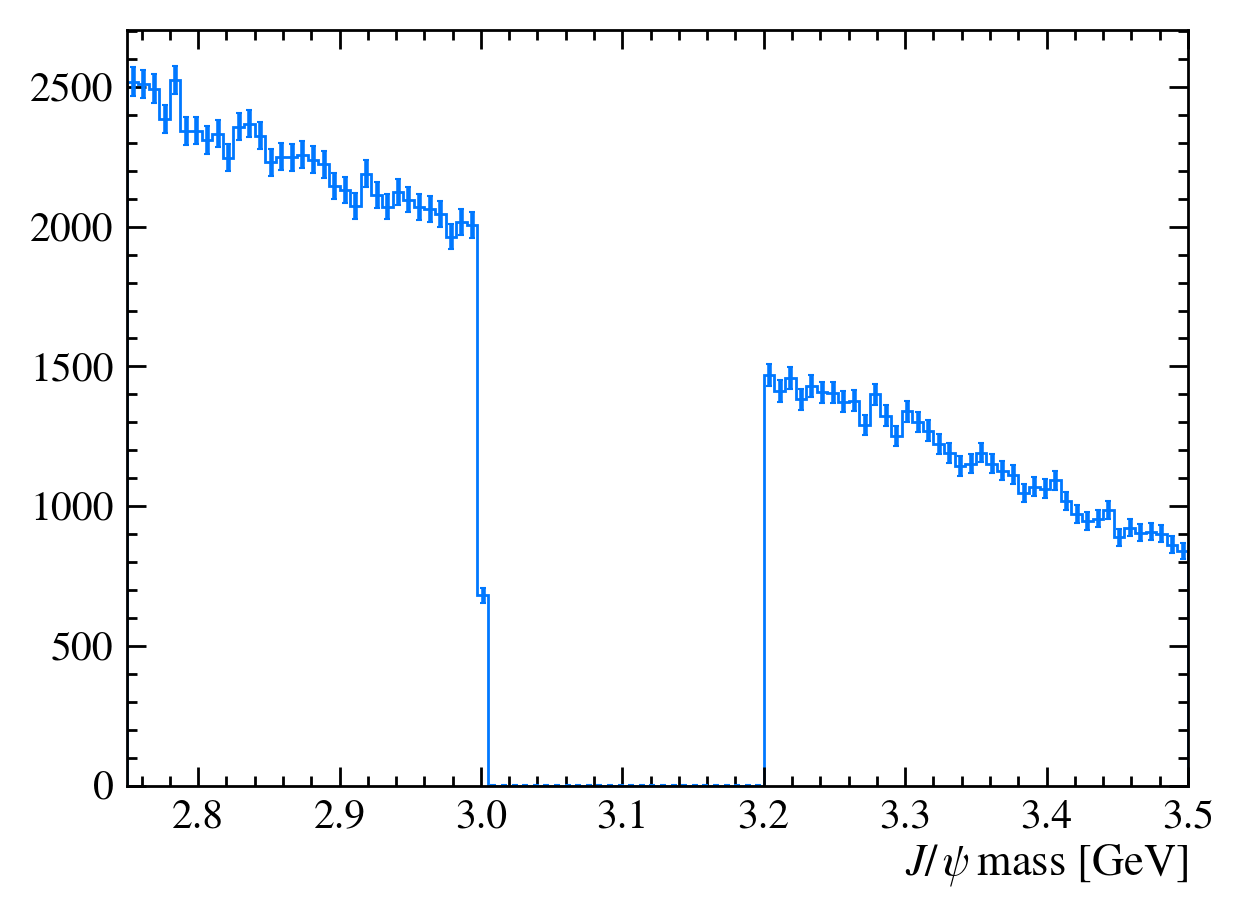

In [20]:
bkg_df = data_df.query('~(3.0 < Jpsi_M < 3.2)')
plot_mass(bkg_df)

**QUESTION:** Why is there a step at 3 GeV on this plot?

It's a binning effect, we've appled a cut at 3.0 GeV but the nearest bin is $[2.9975, 3.005]$ so it is only partially filled.

Now let's plot the variables in MC and background to see what they look like?

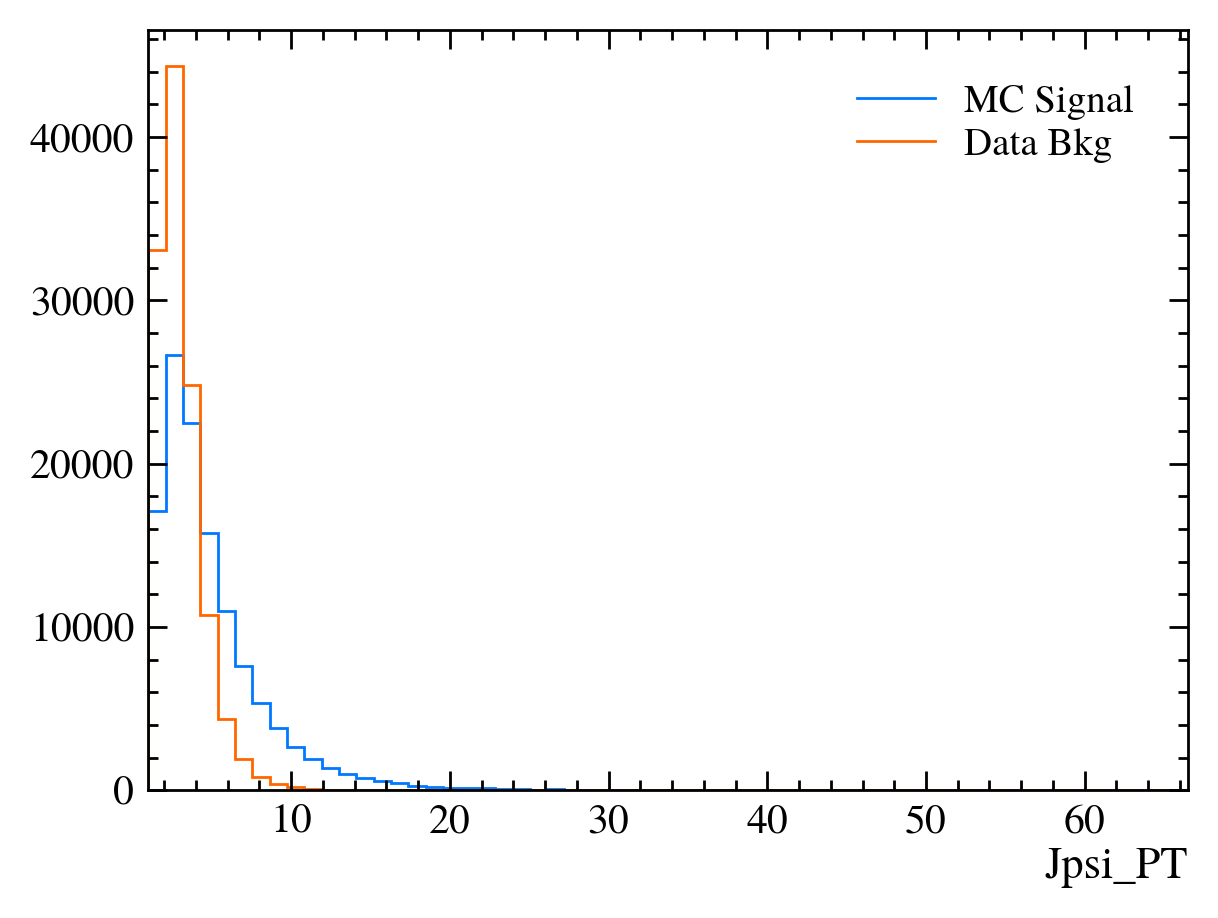

In [21]:
var = 'Jpsi_PT'
# let's first create the histograms
hsig, bins = np.histogram(mc_df[var], bins=60)
hbkg, bins = np.histogram(bkg_df[var], bins=bins)  # using the same bins here
# then plot them
mplhep.histplot((hsig, bins), label='MC Signal')
mplhep.histplot(hbkg, bins=bins, label='Data Bkg')
plt.xlabel(var)
plt.xlim(bins[0], bins[-1])
plt.legend(loc='best')

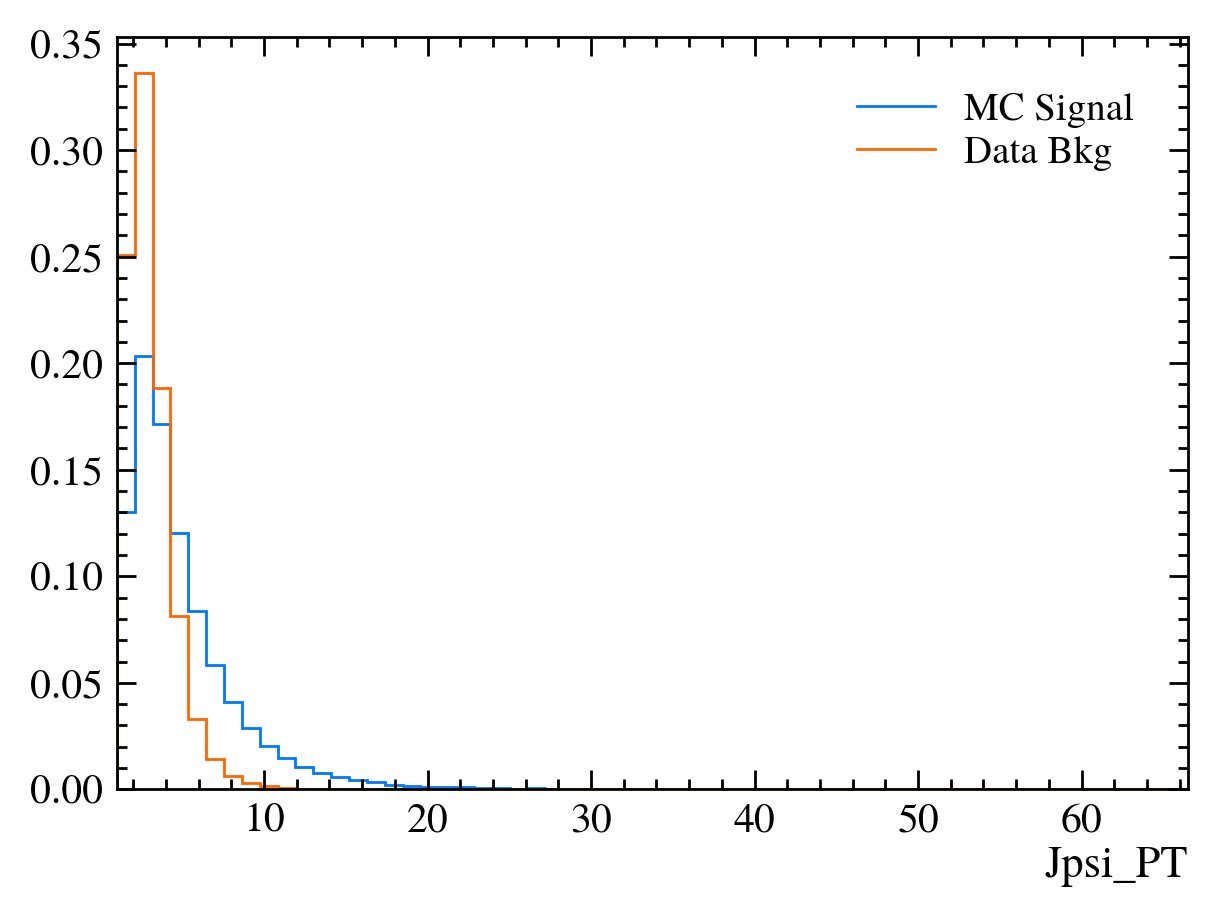

In [22]:
# Those are hard to compare!
# We can add the density keyword argument to normalise the distributions

mplhep.histplot(hsig, bins=bins, label='MC Signal', density=1)
mplhep.histplot(hbkg, bins=bins, label='Data Bkg', density=1)
plt.xlabel(var)
plt.xlim(bins[0], bins[-1])
plt.legend(loc='best')

**Exercise:** Make a function which plots both variables with the signature `plot_comparision(var, mc_df, bkg_df)`.

In [23]:
def plot_comparision(var, mc_df, bkg_df):
    # create histograms
    hsig, bins = np.histogram(mc_df[var], bins=60, density=1)
    hbkg, bins = np.histogram(bkg_df[var], bins=bins, density=1)

    mplhep.histplot((hsig, bins), label='MC Signal', )
    mplhep.histplot(hbkg, bins=bins, label='Data Bkg')
    plt.xlabel(var)
    plt.xlim(bins[0], bins[-1])
    plt.legend(loc='best')

We can now use this function to plot all of the variables available in the data using `data_df.columns`:

/tmp/ipykernel_5916/3447827755.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # creates a new figure


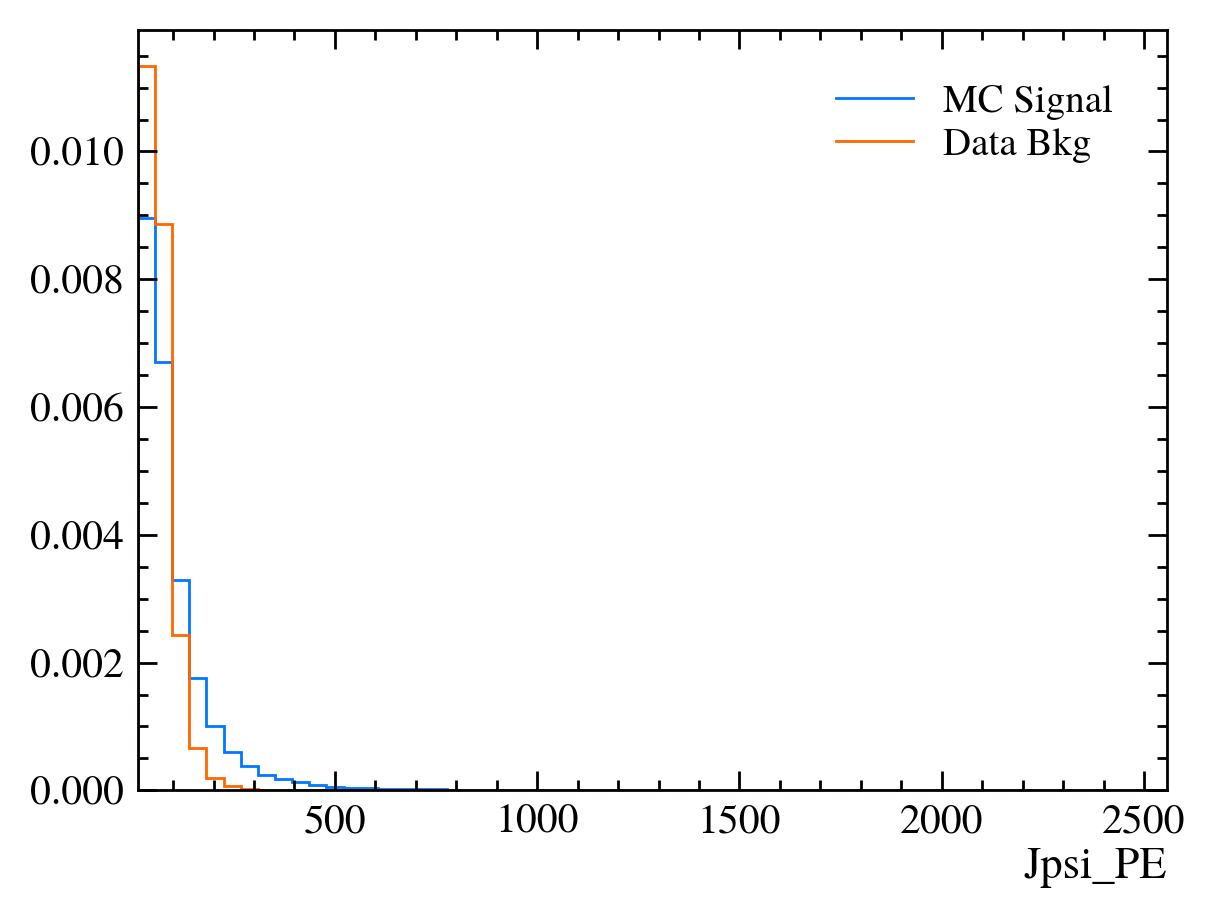

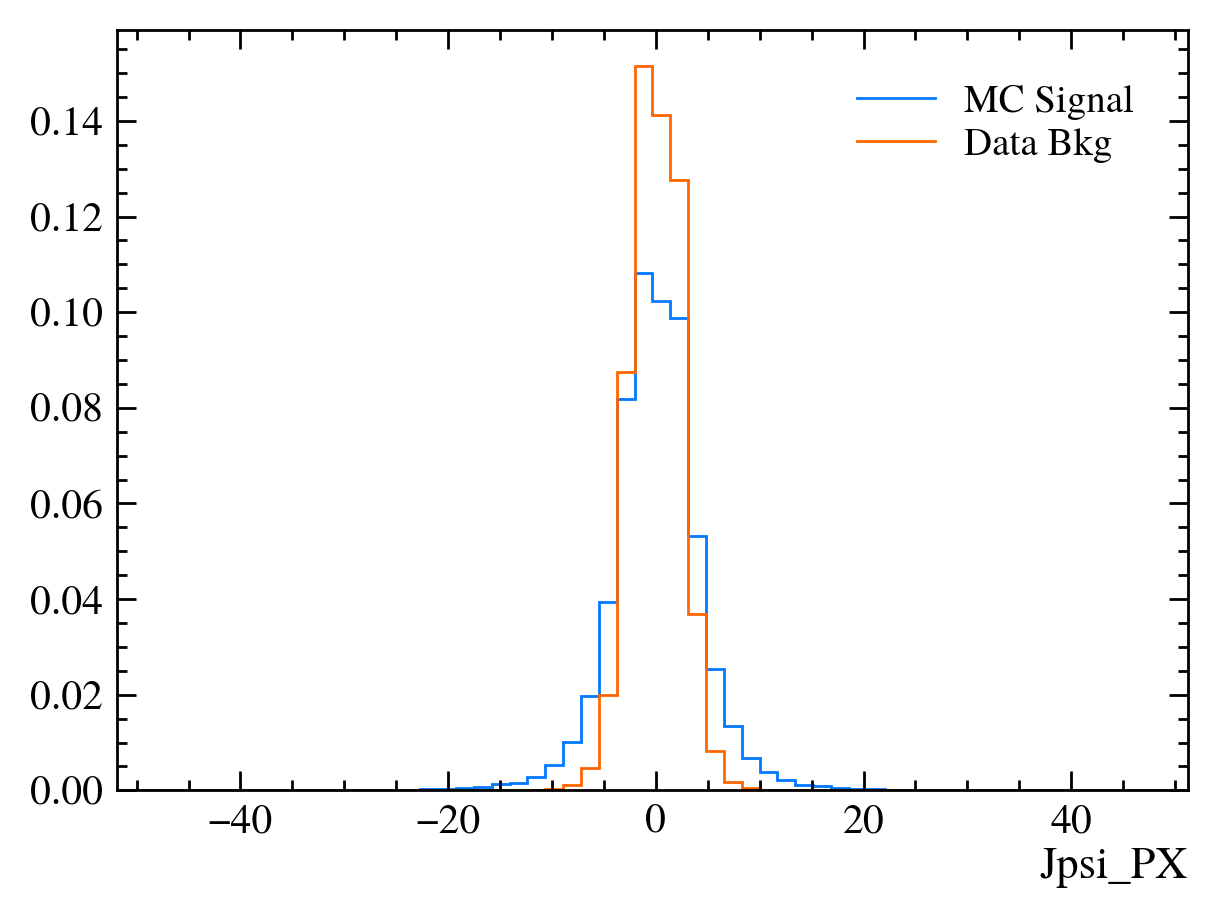

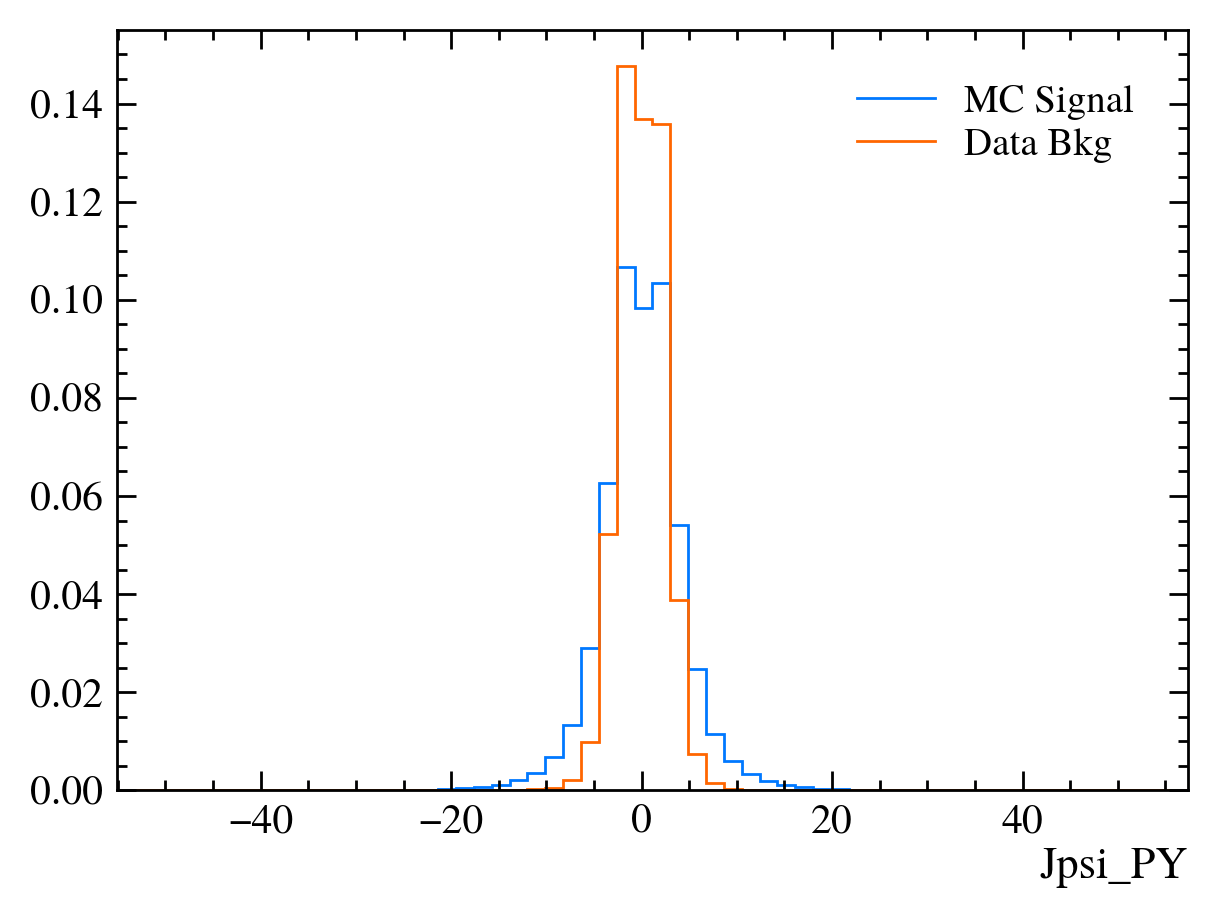

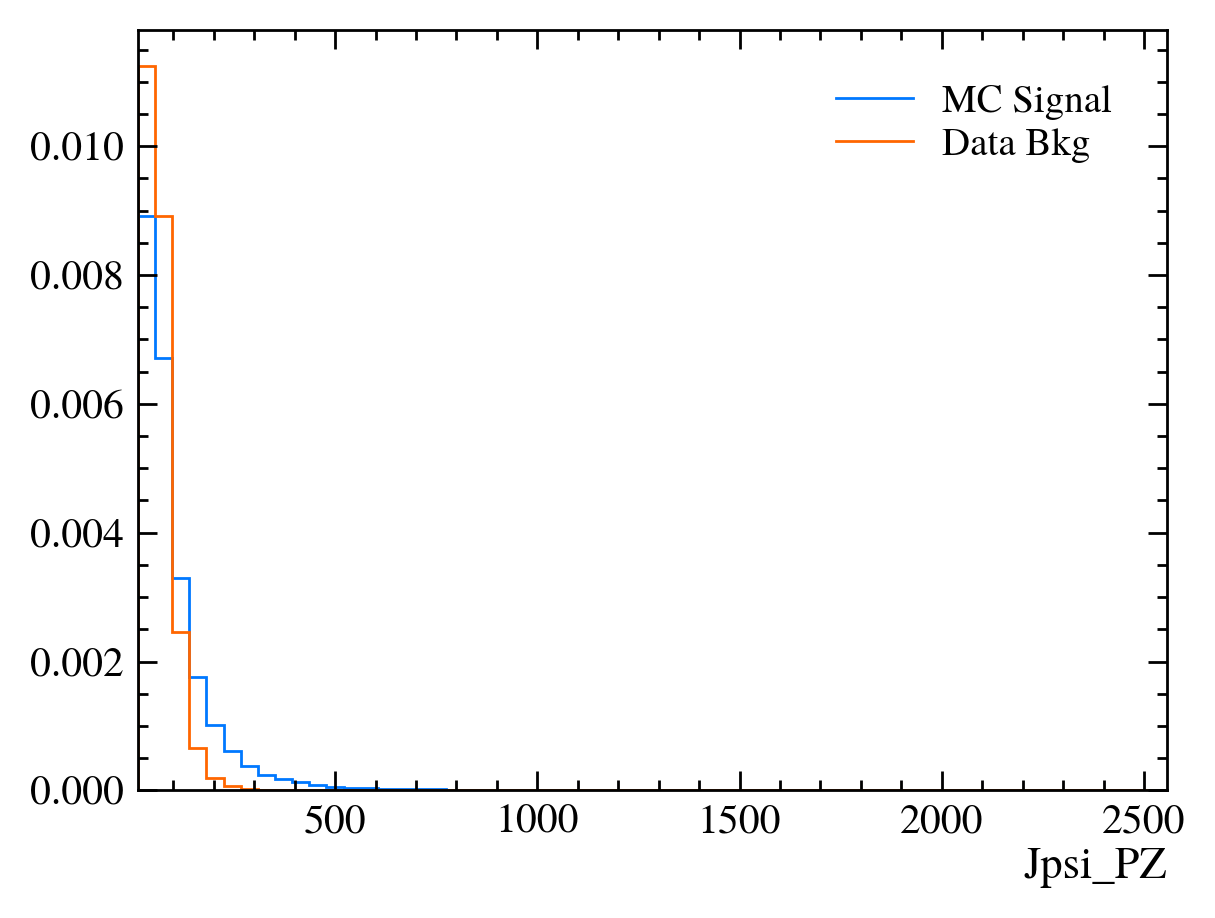

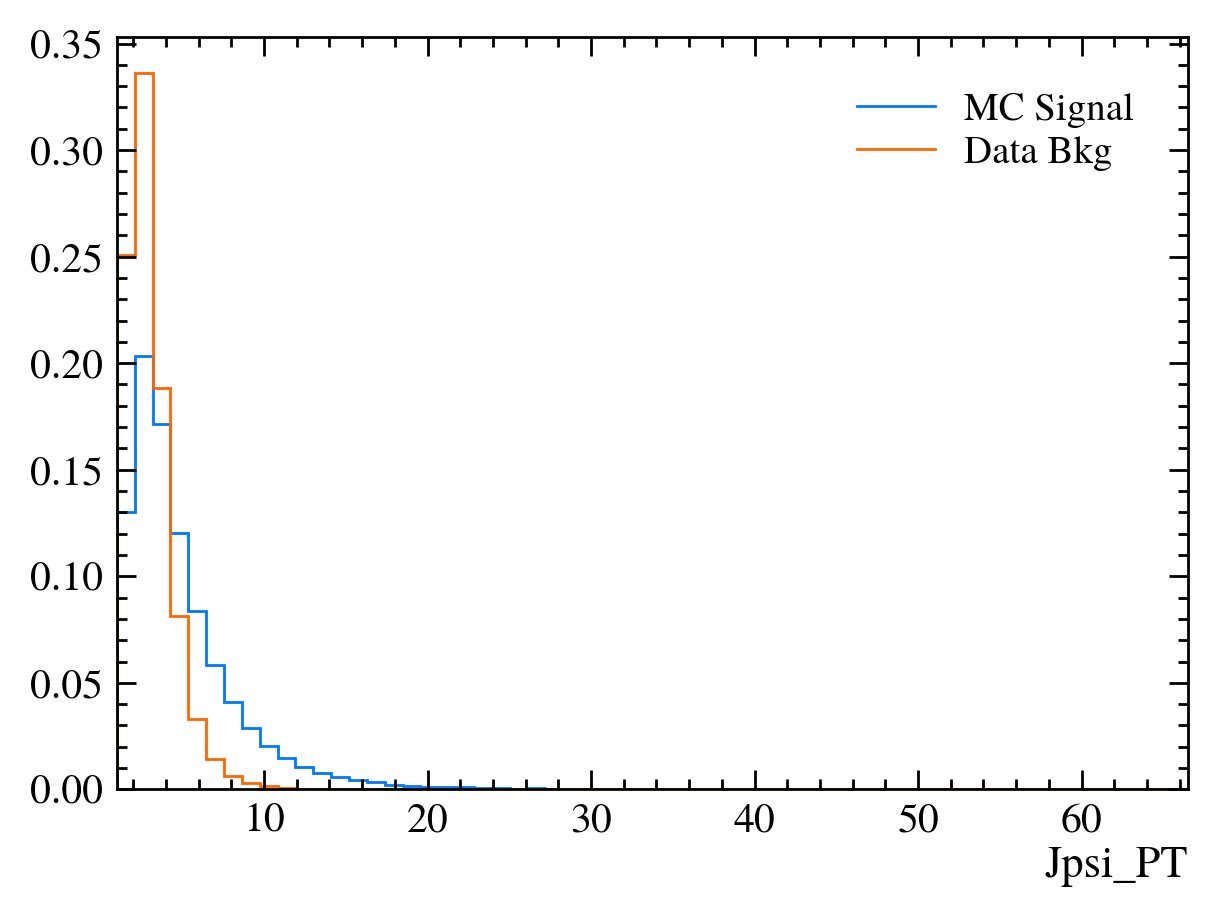

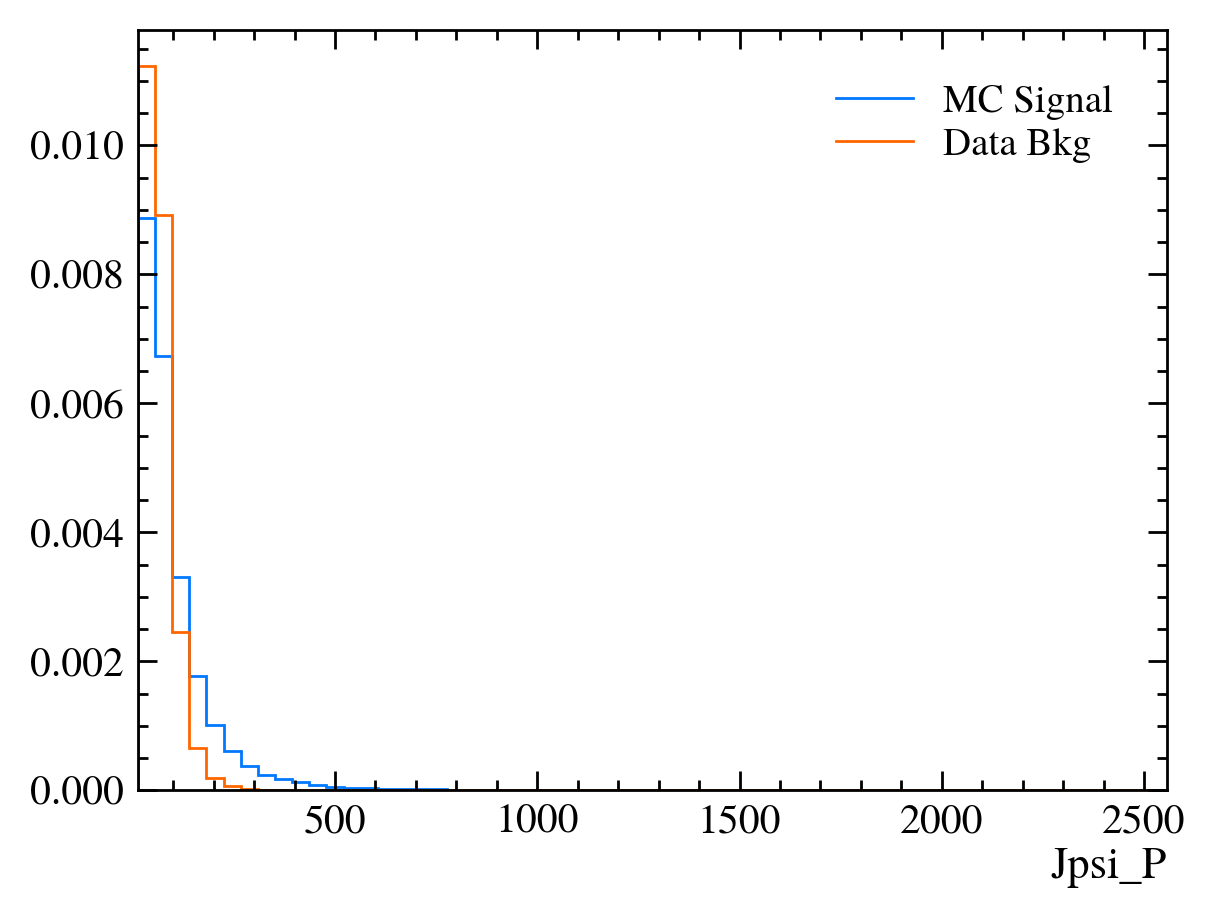

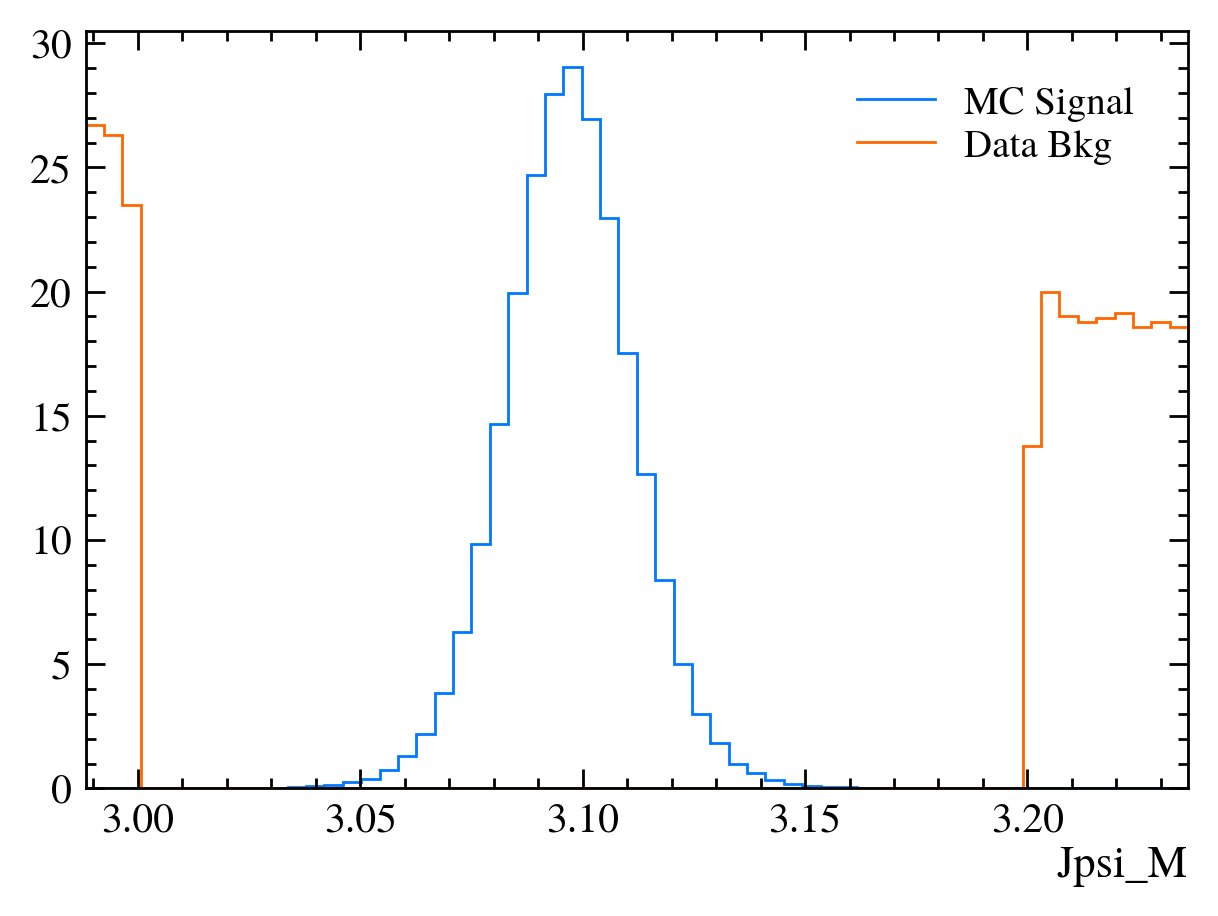

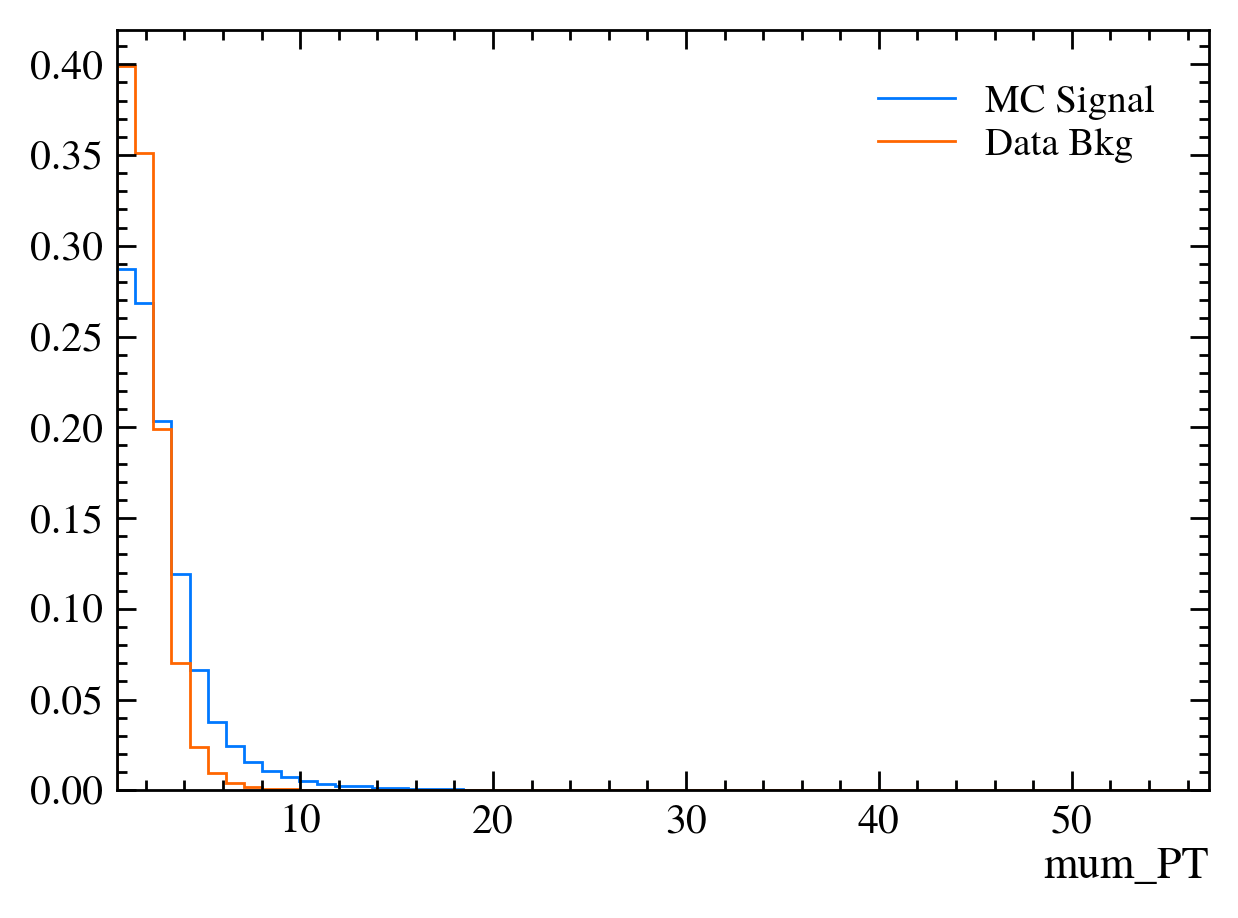

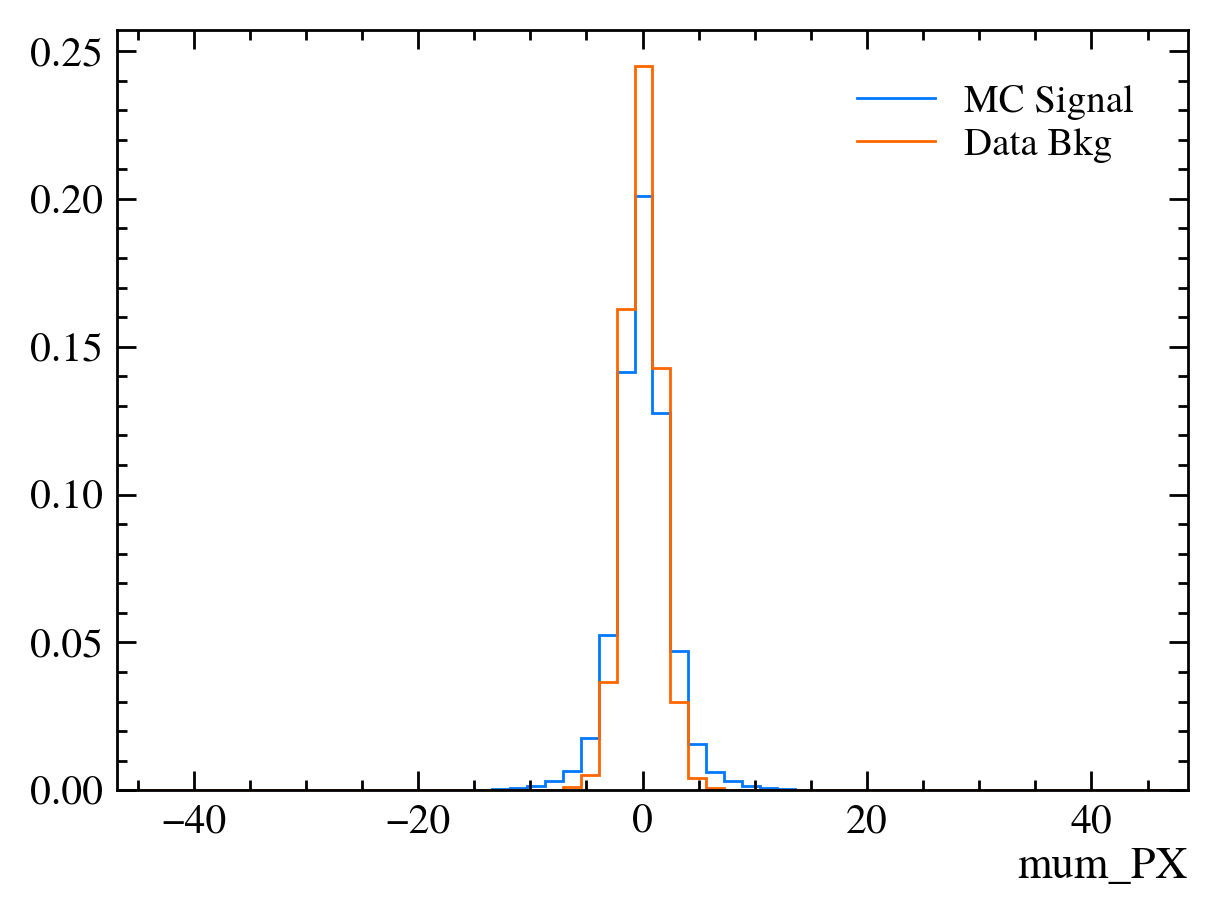

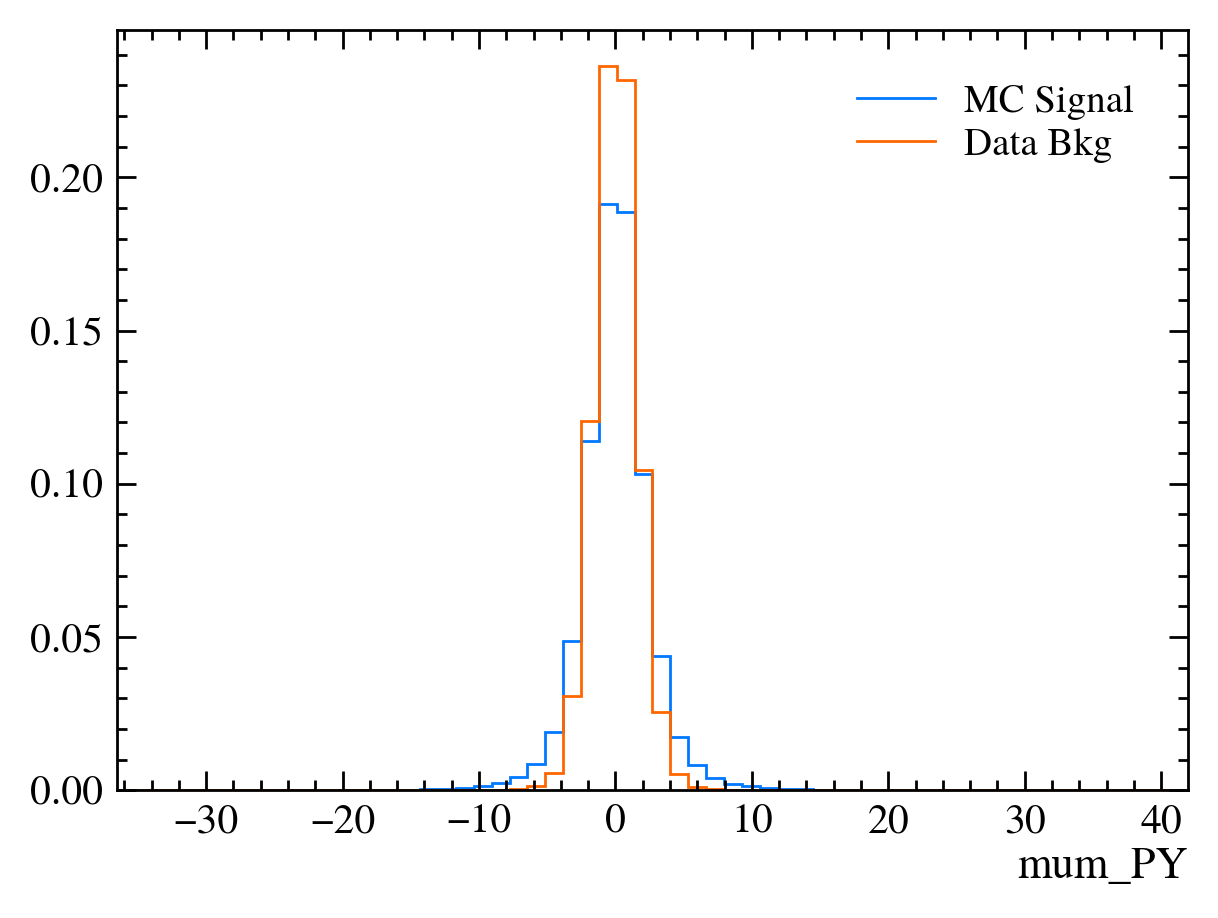

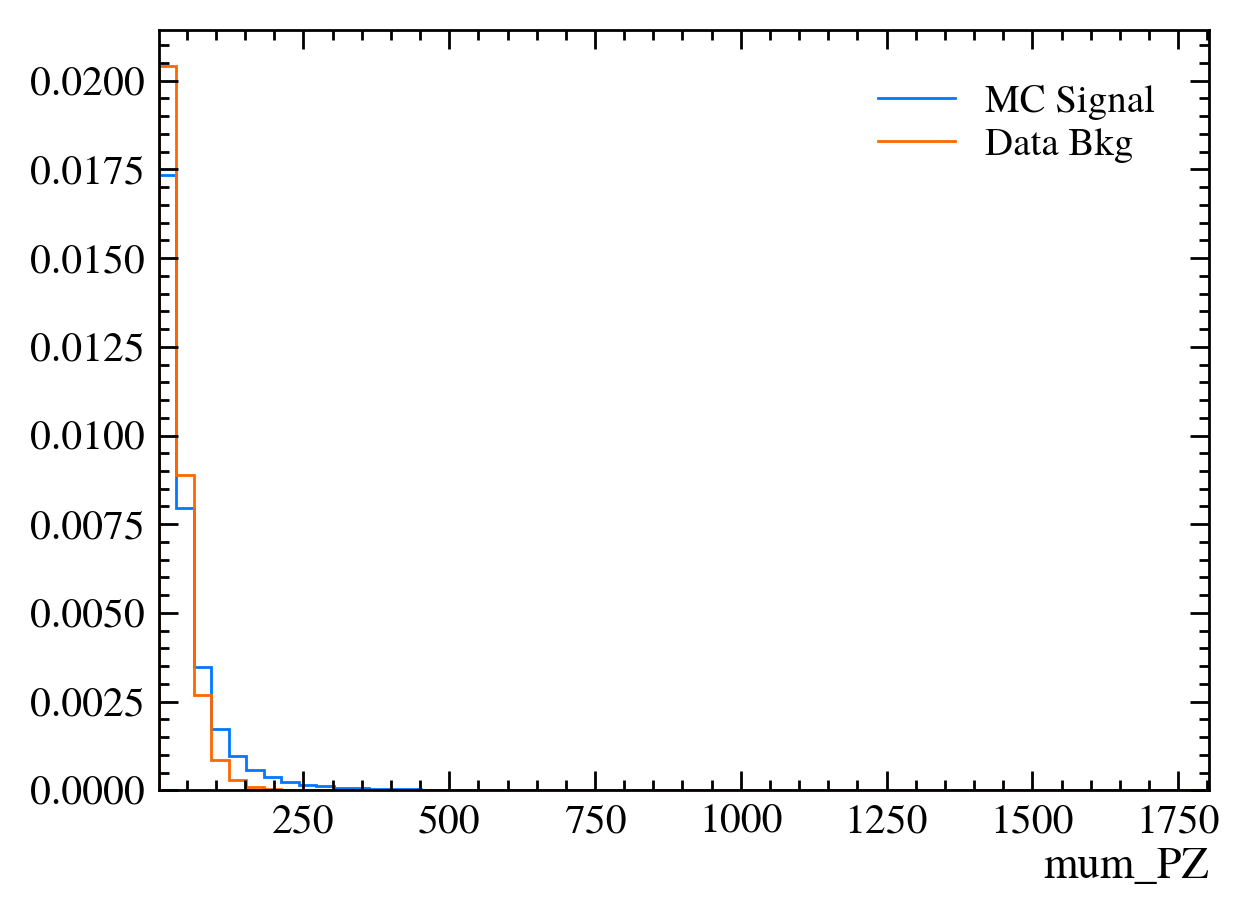

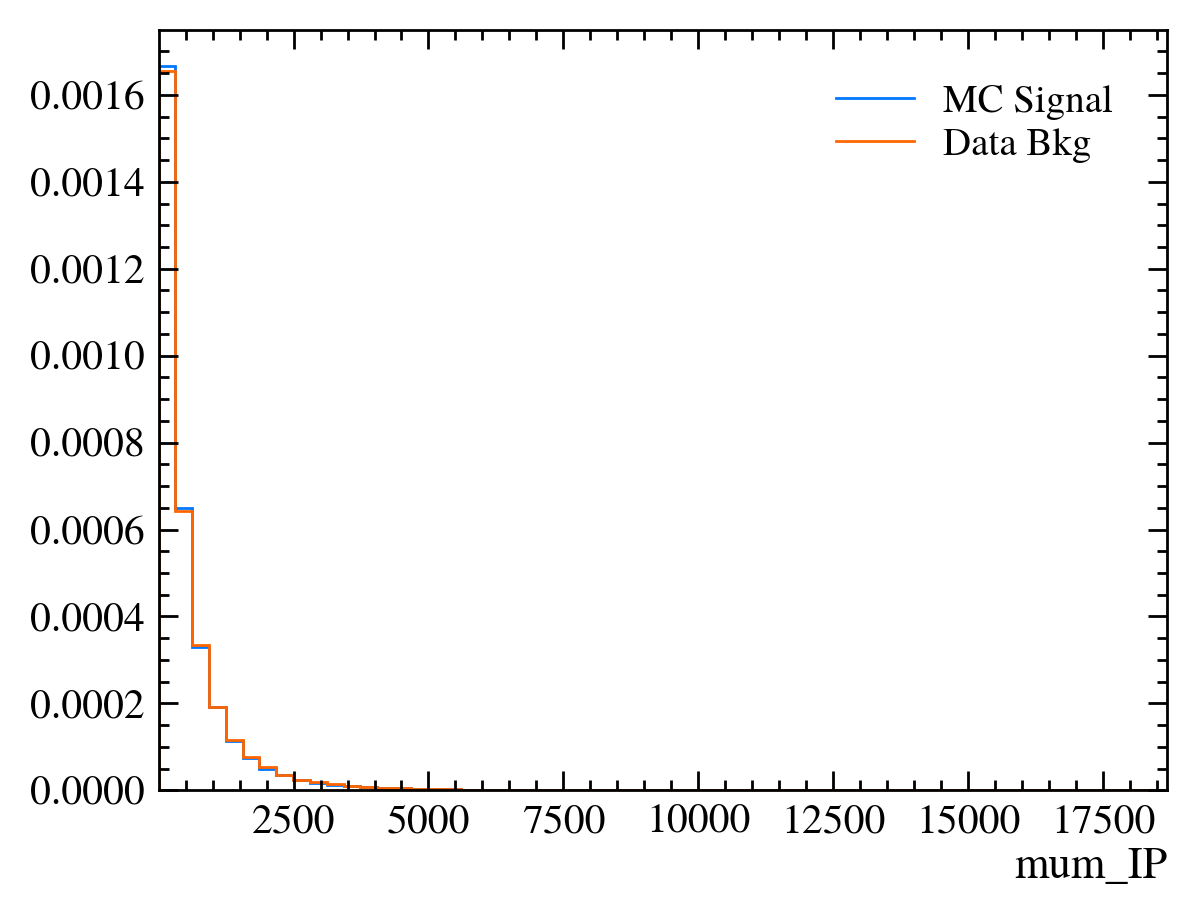

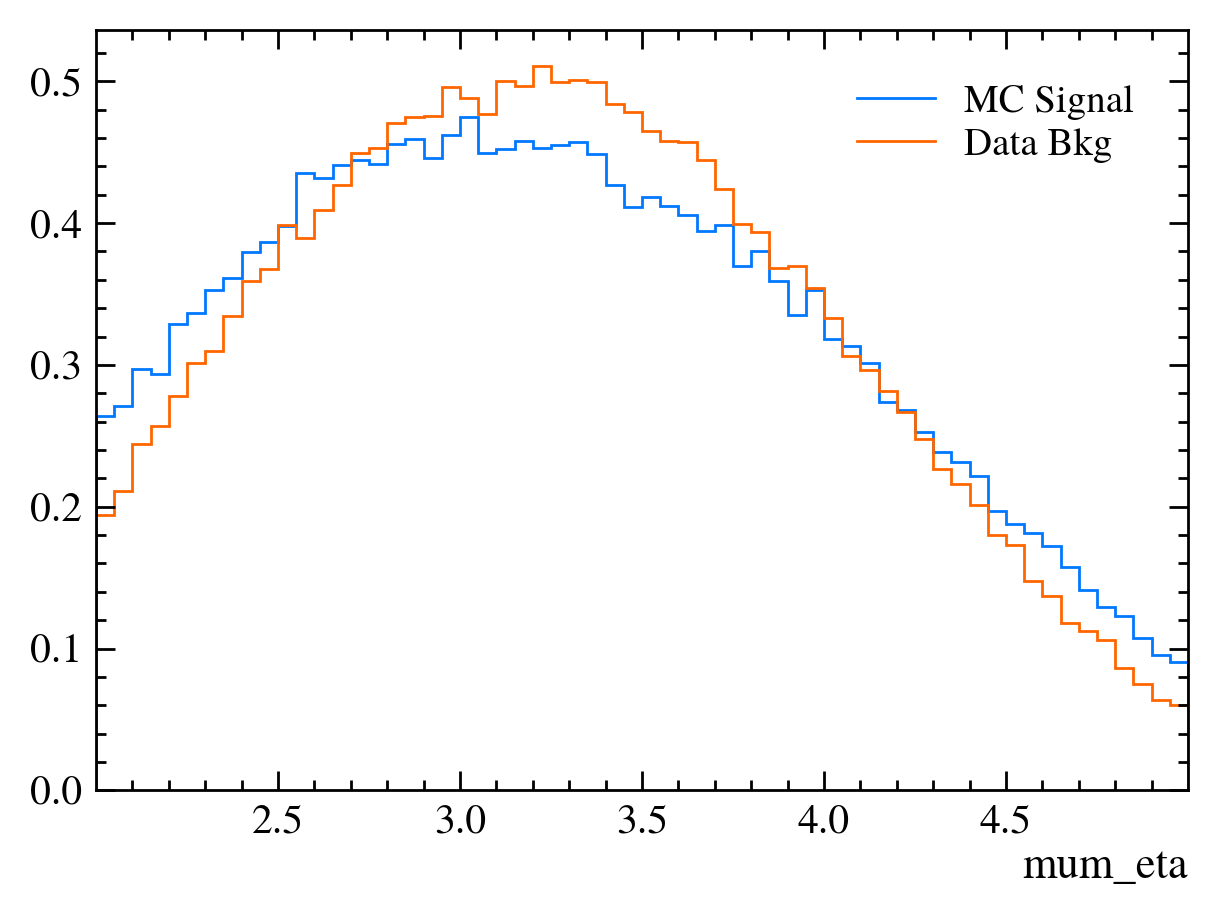

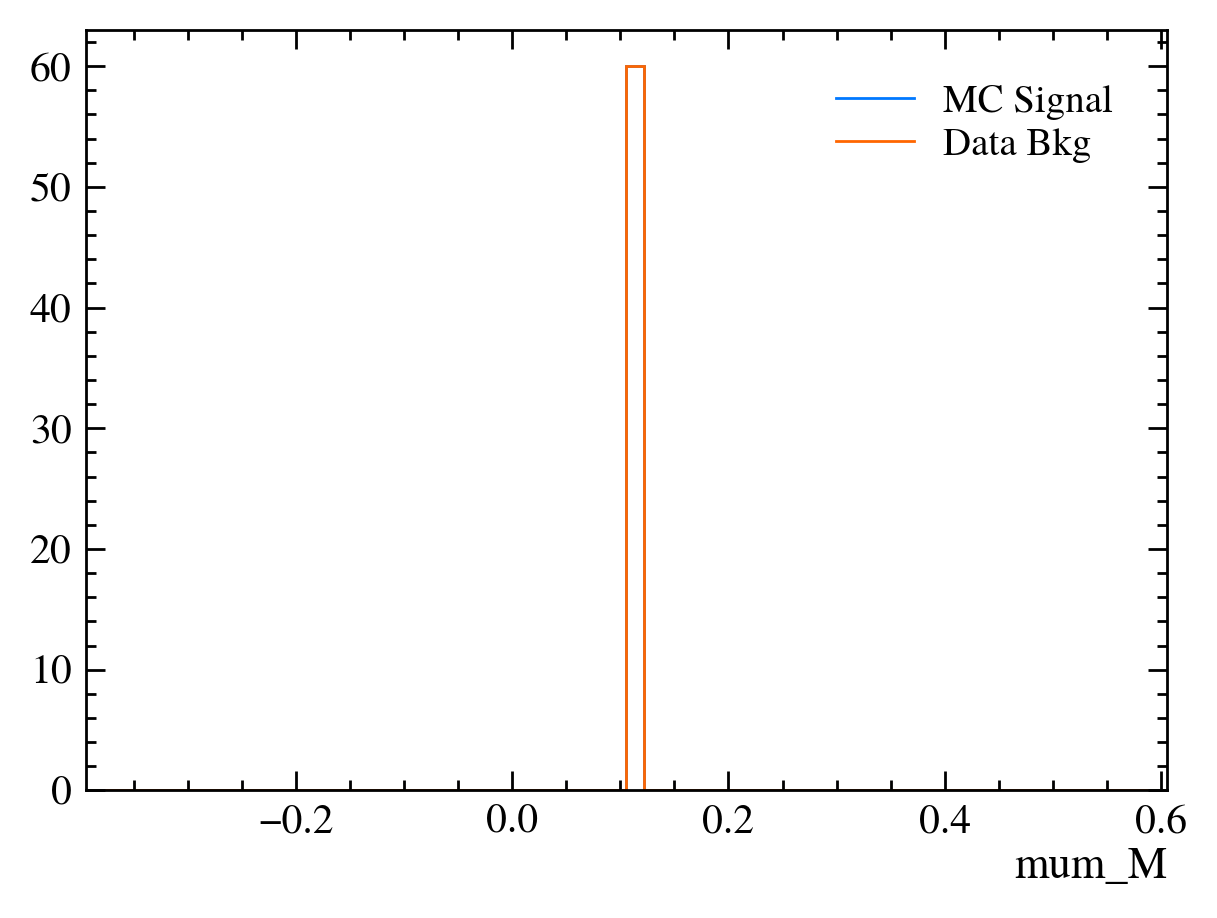

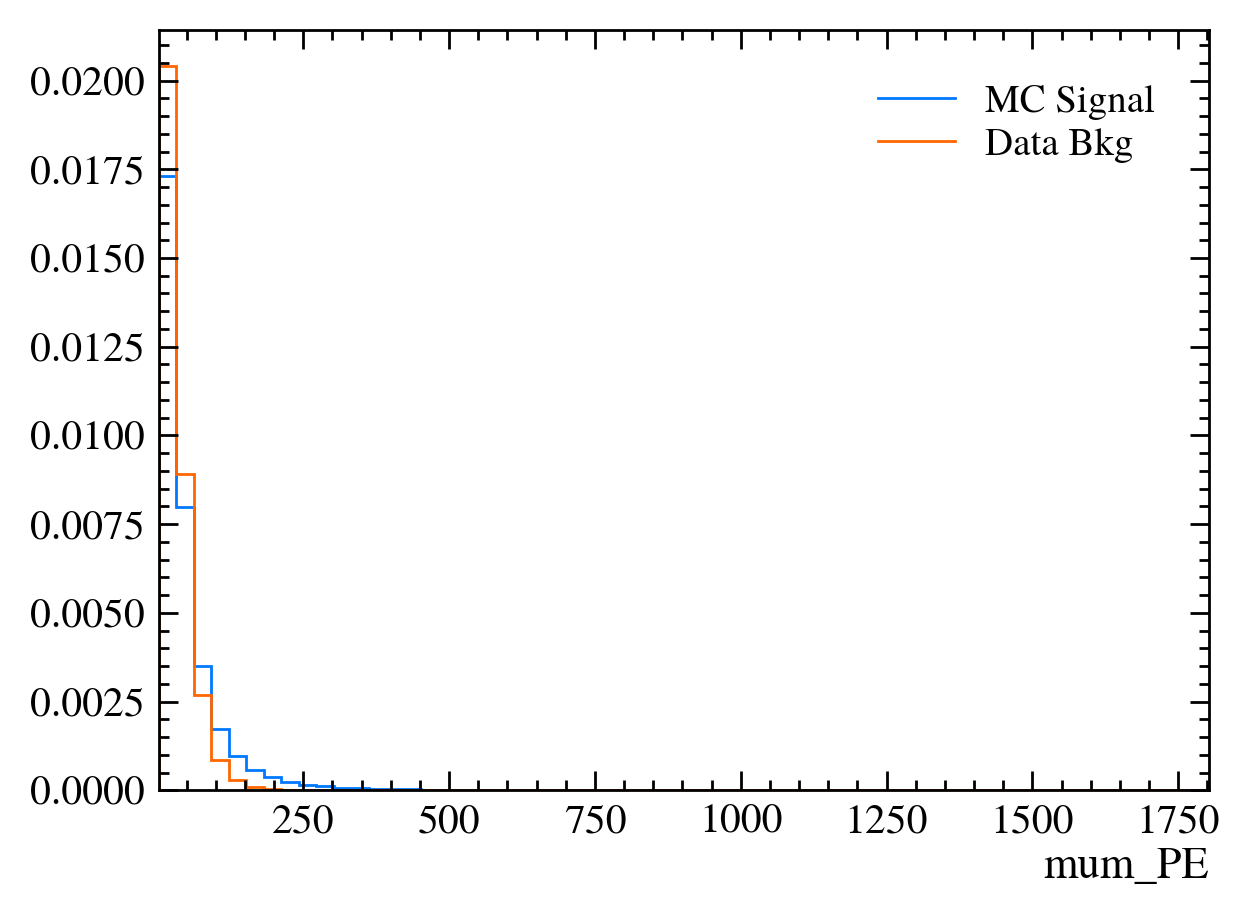

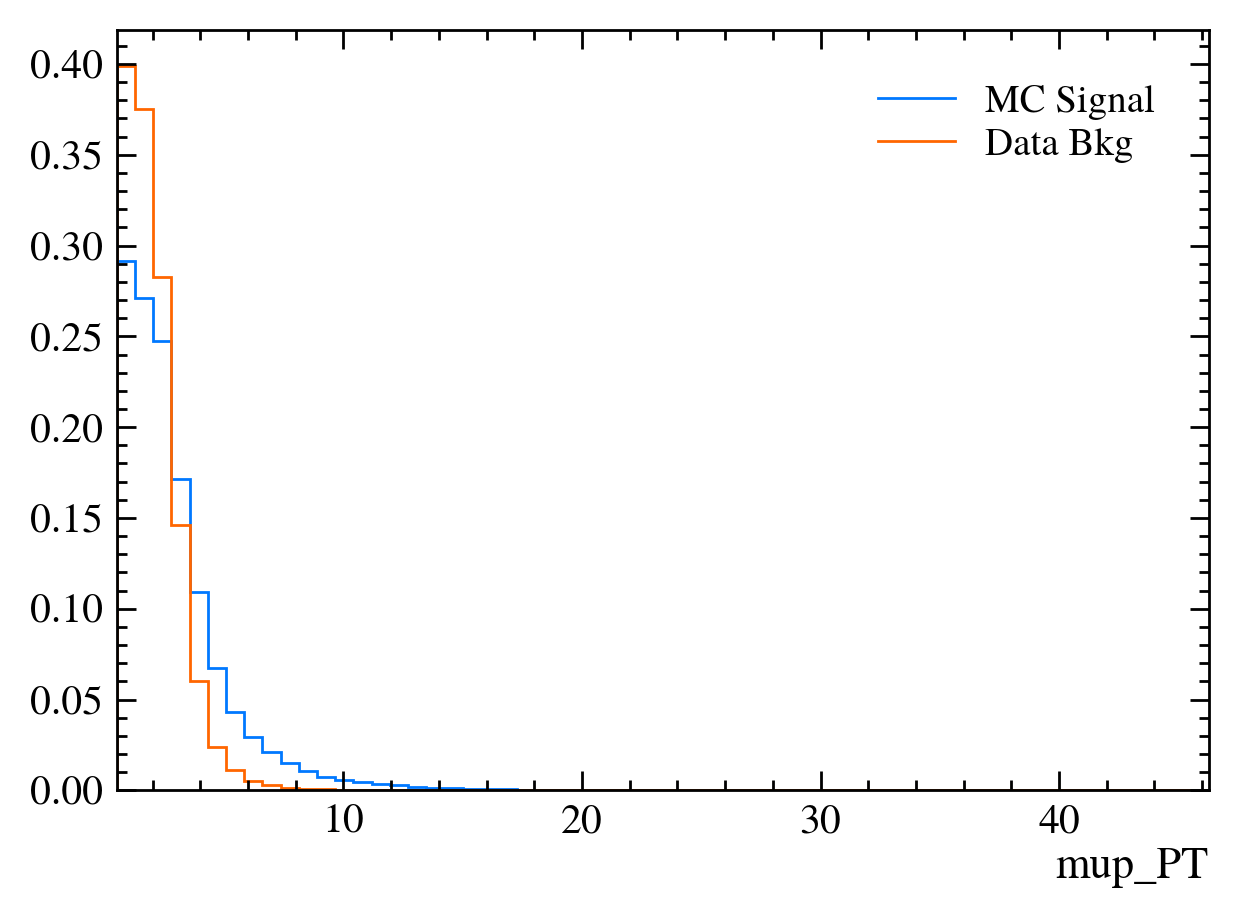

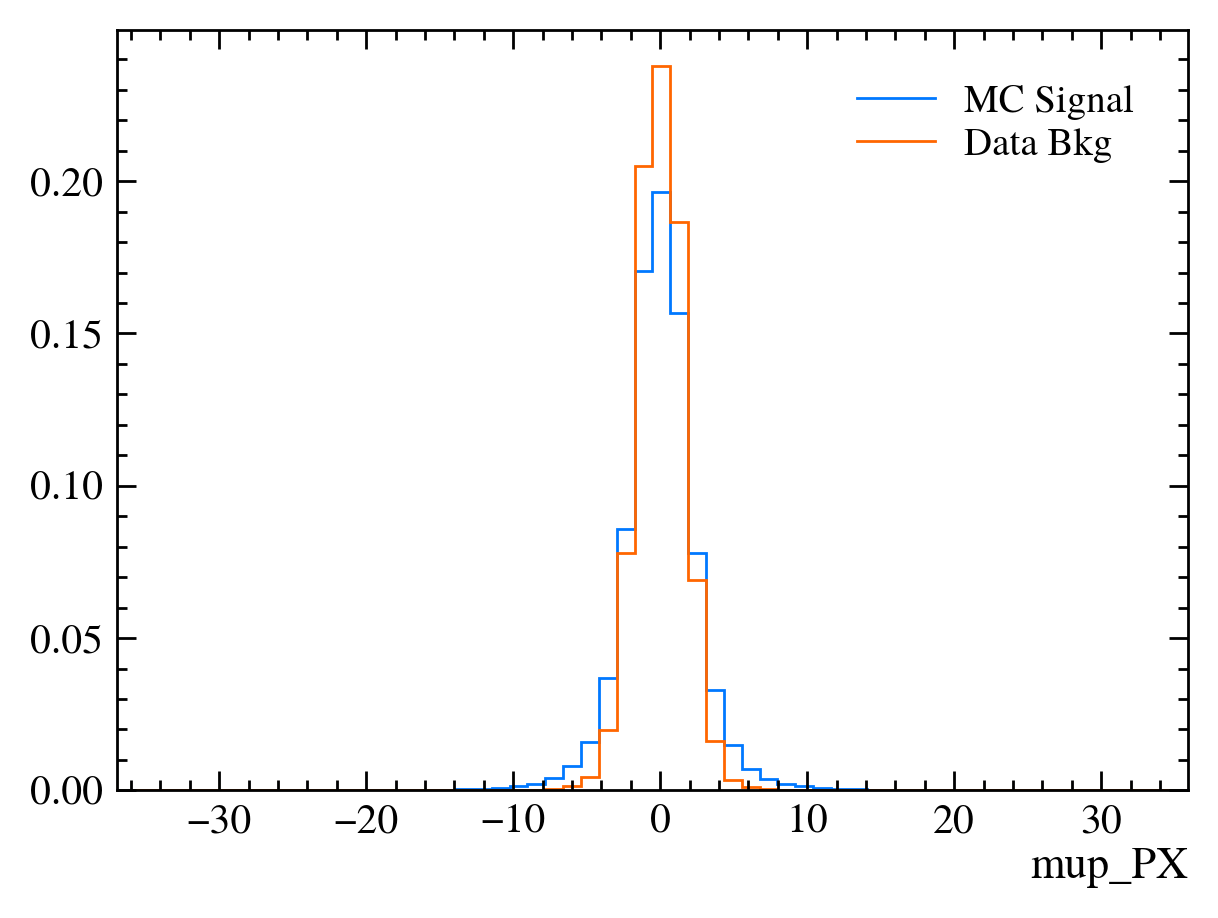

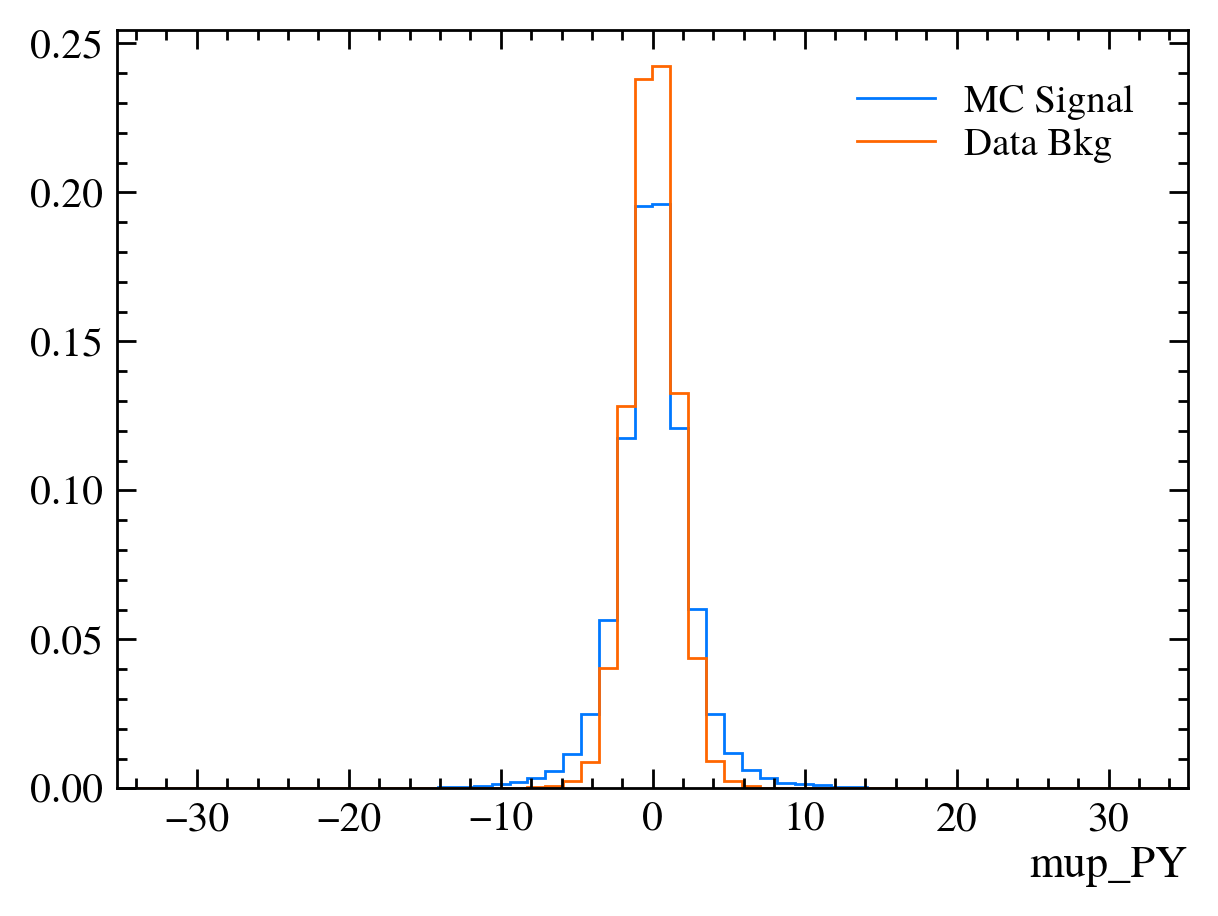

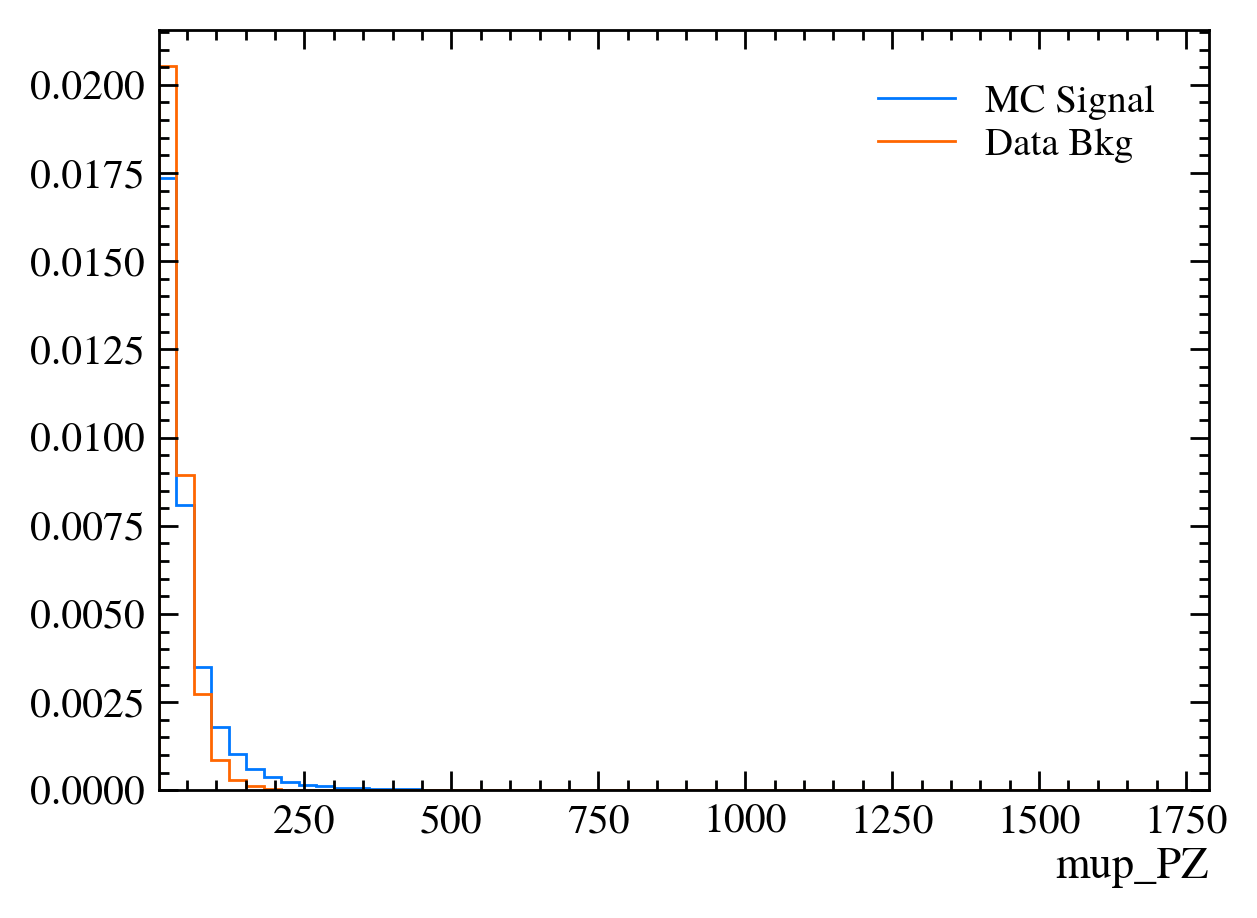

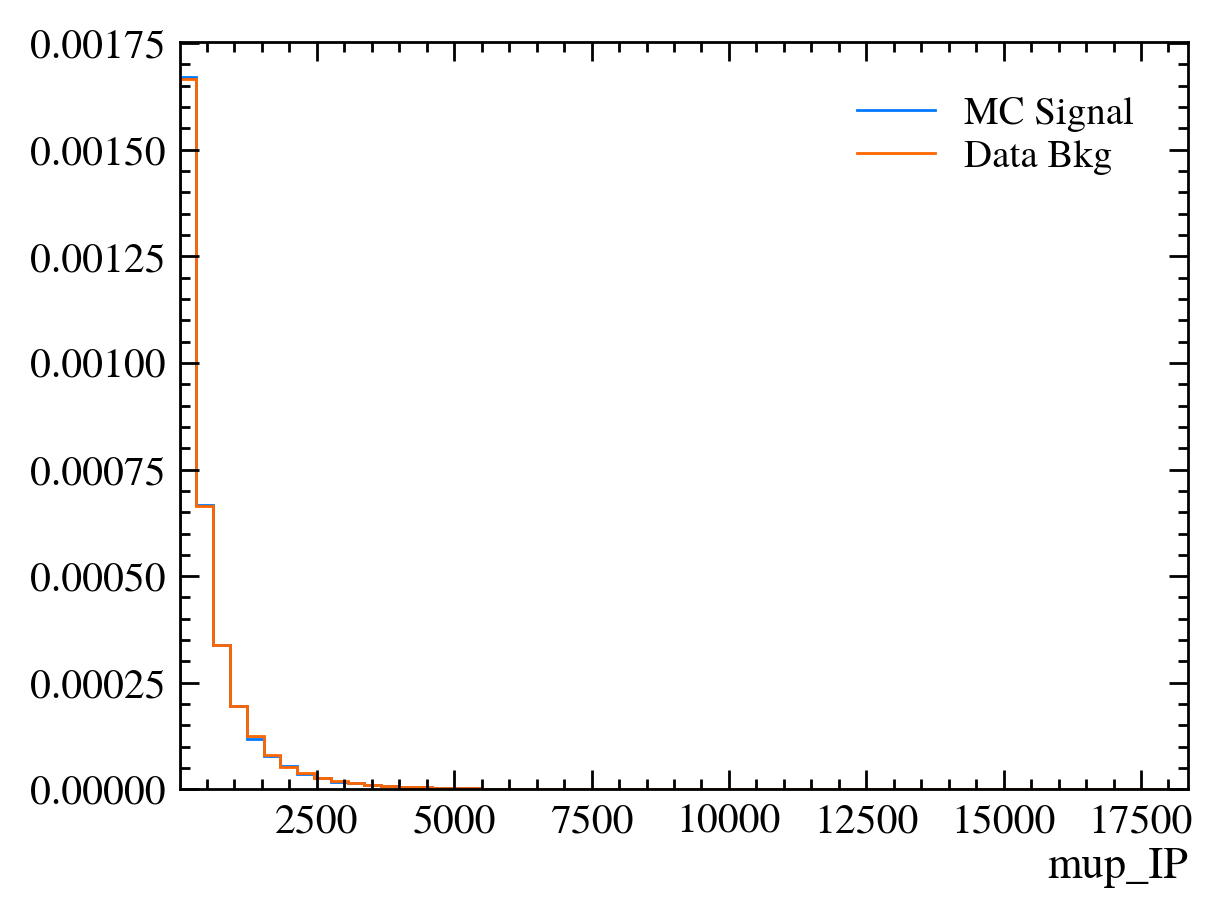

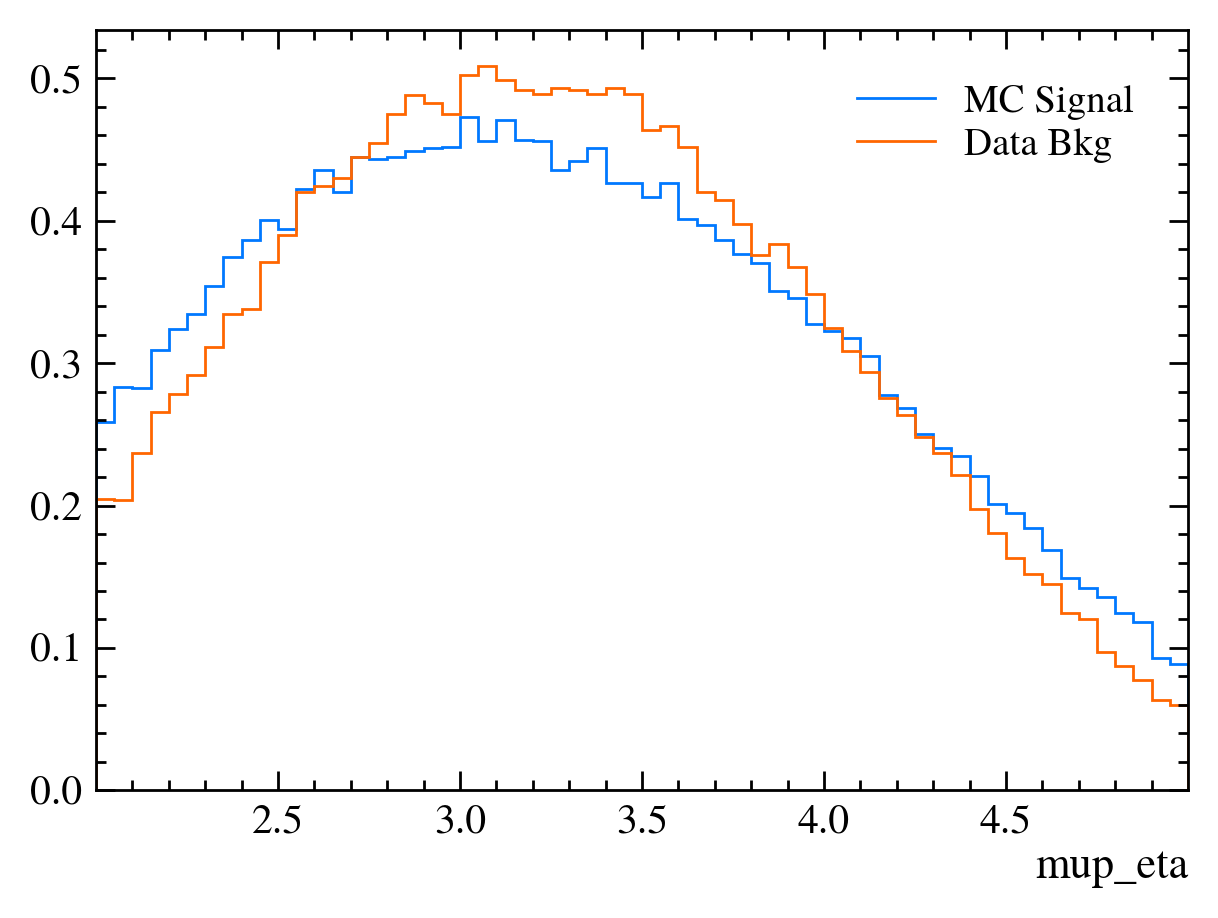

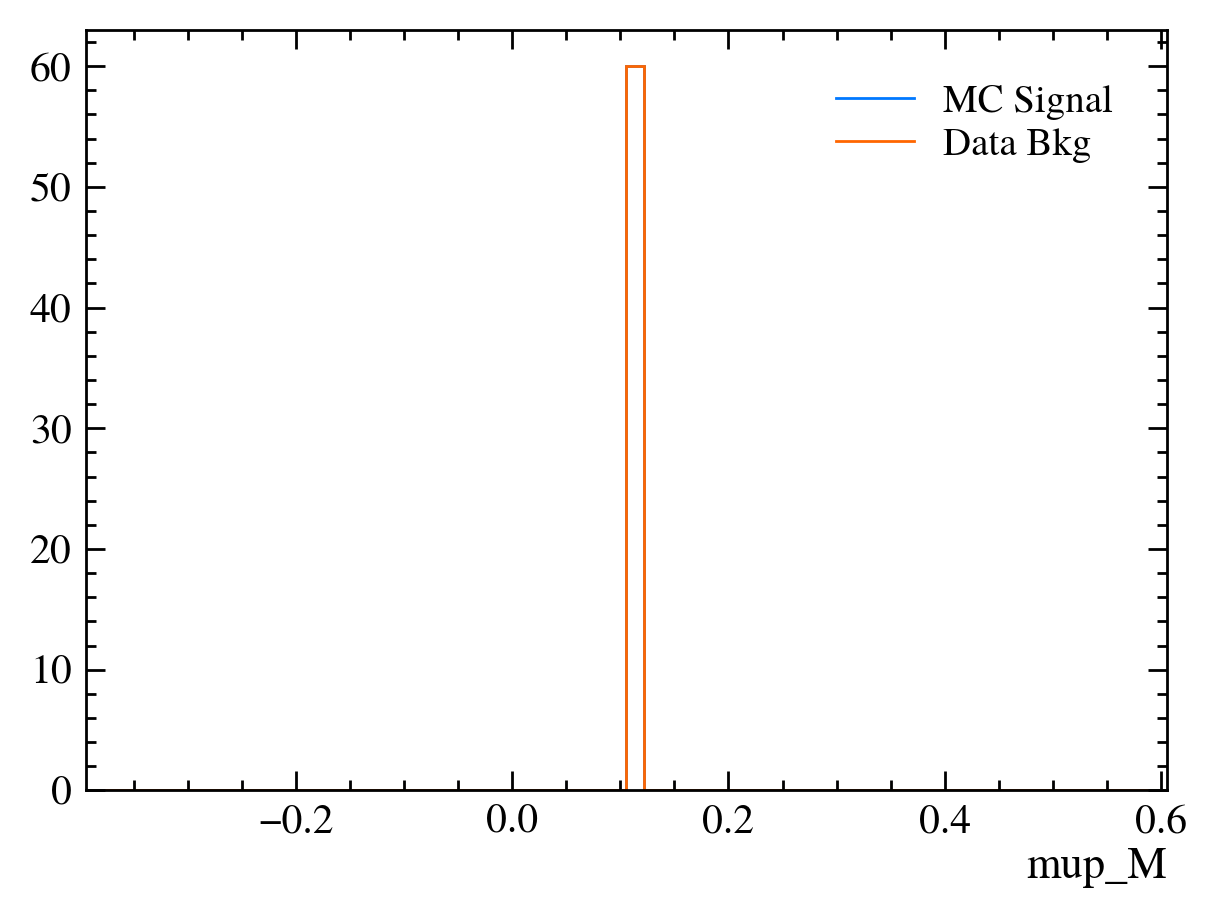

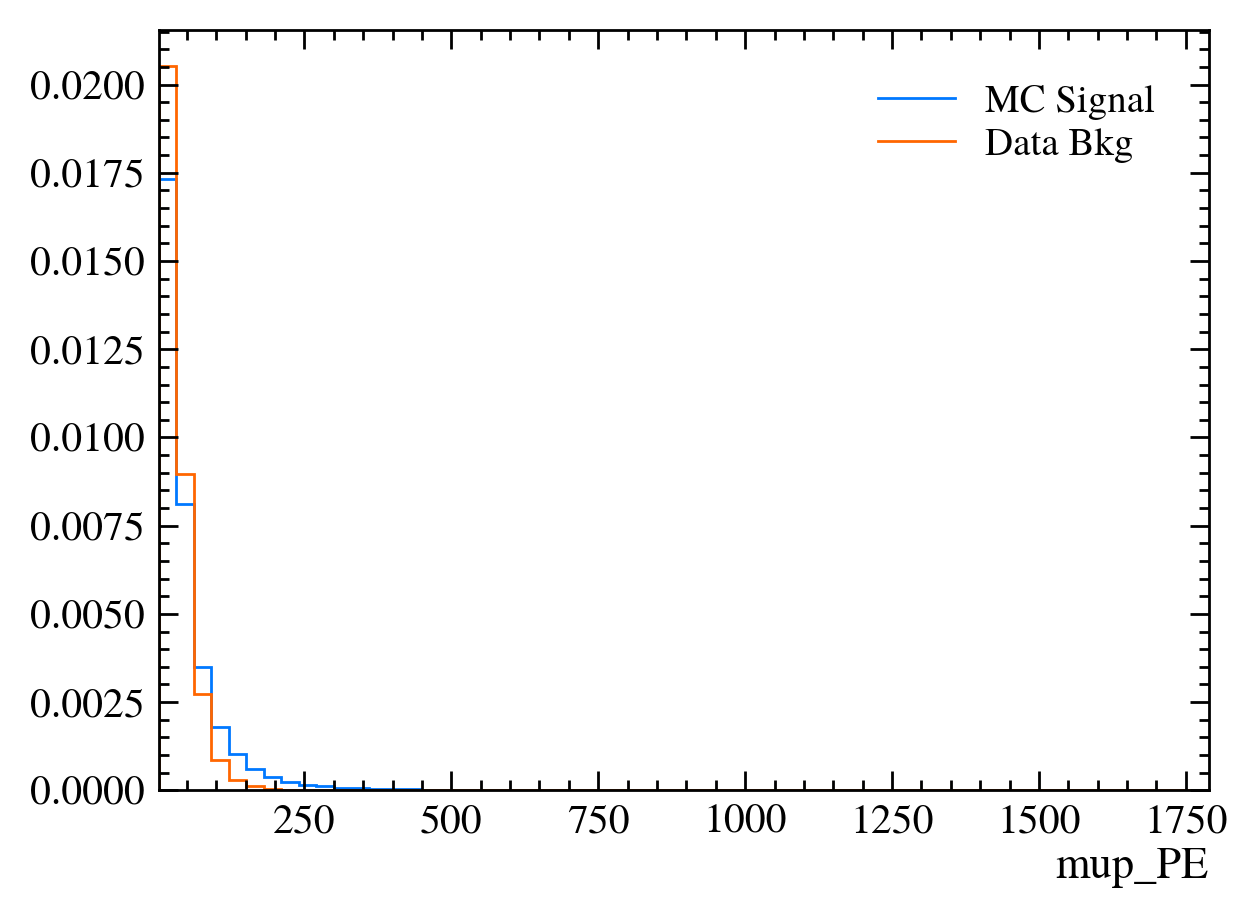

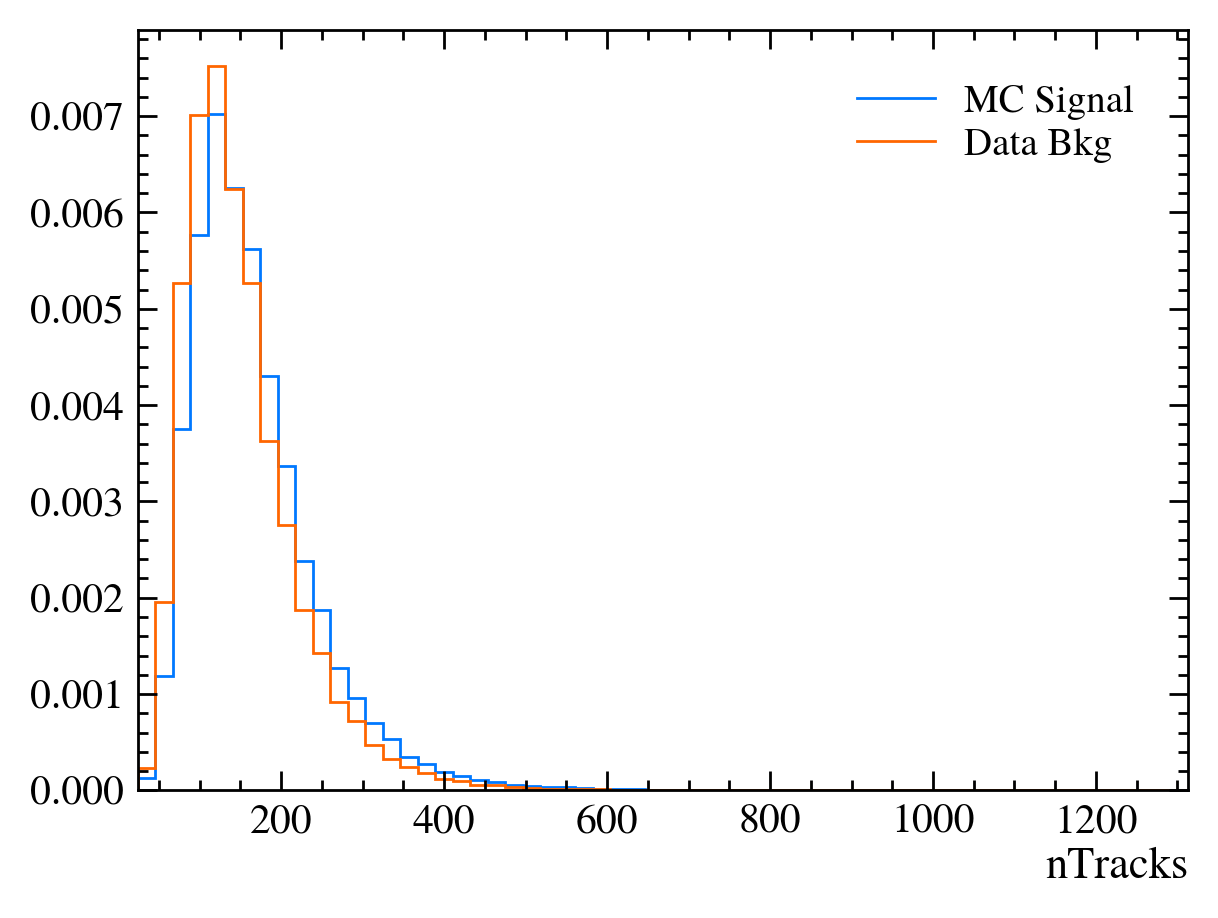

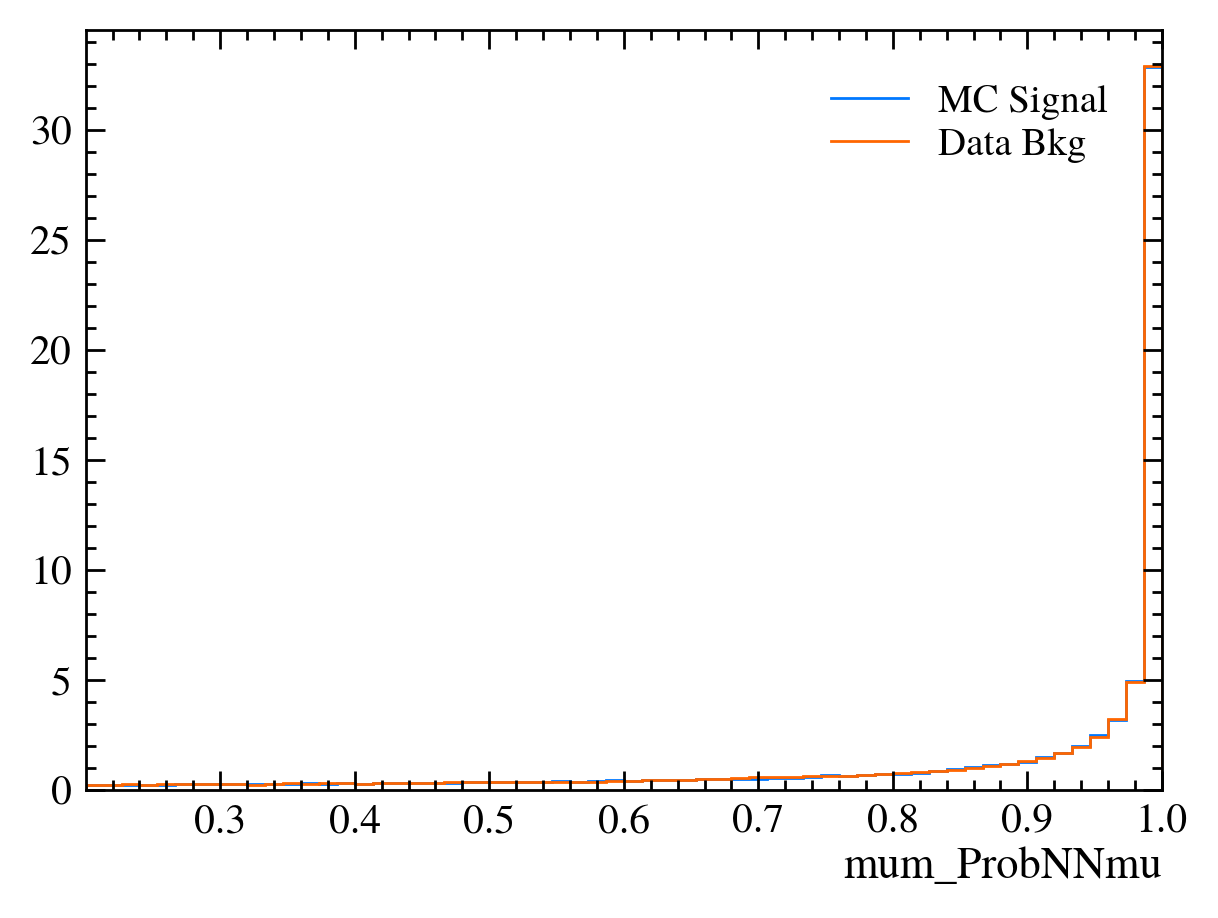

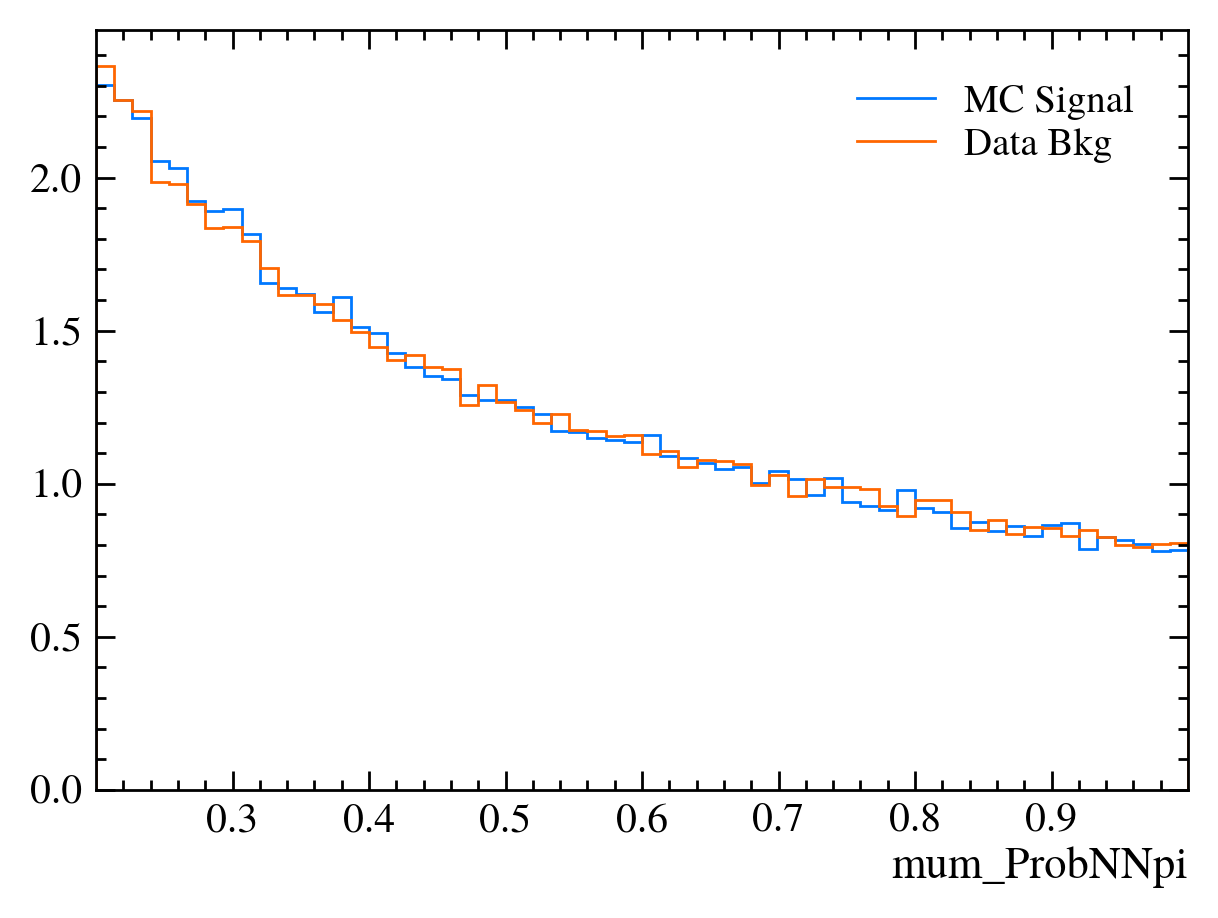

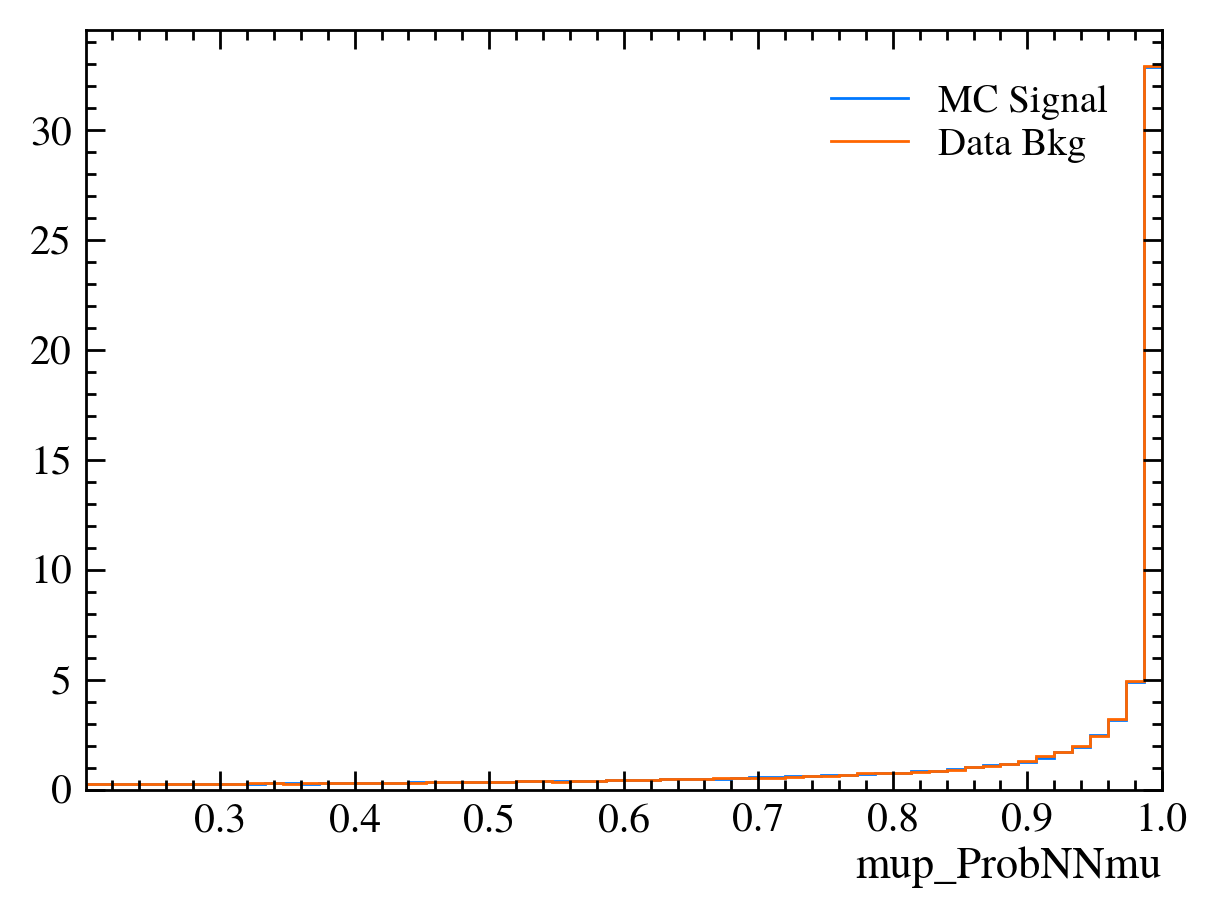

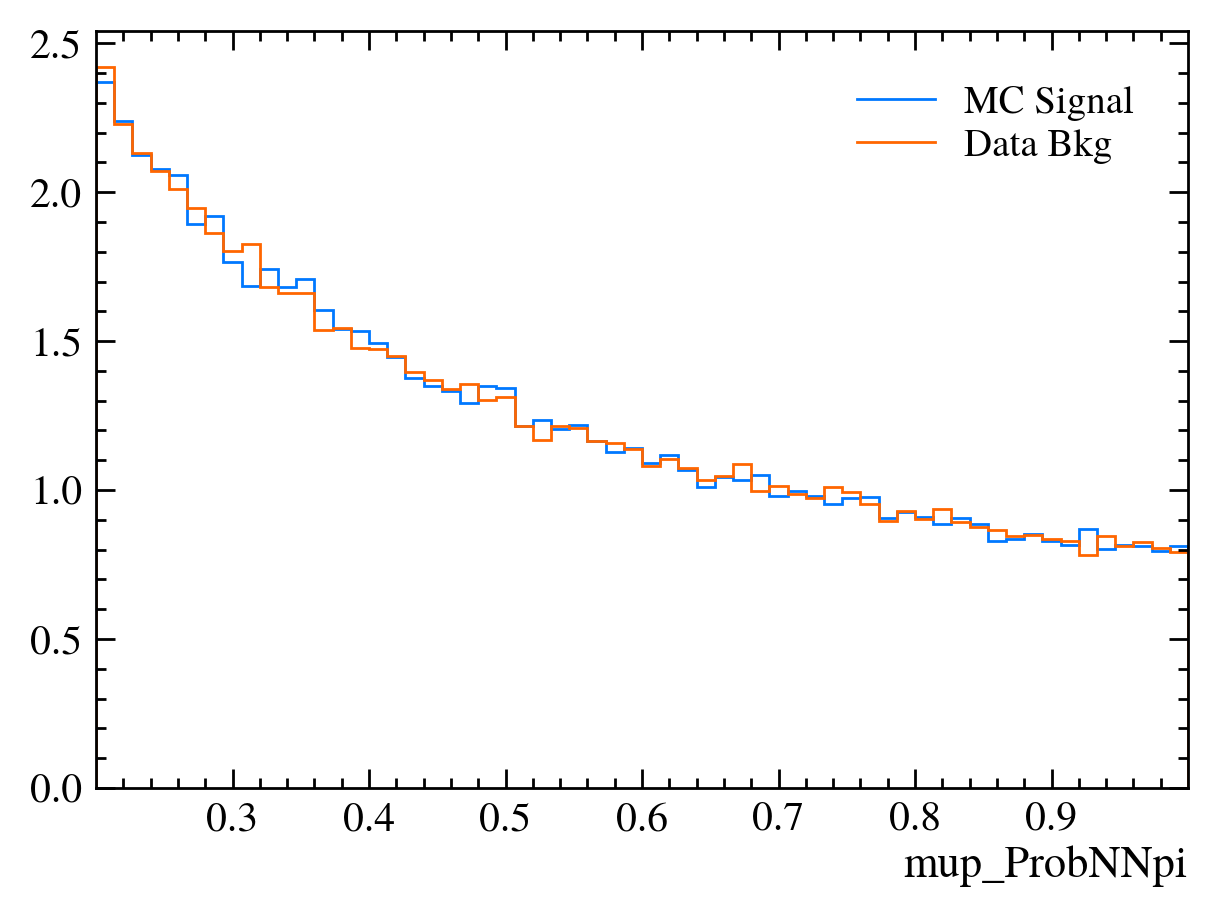

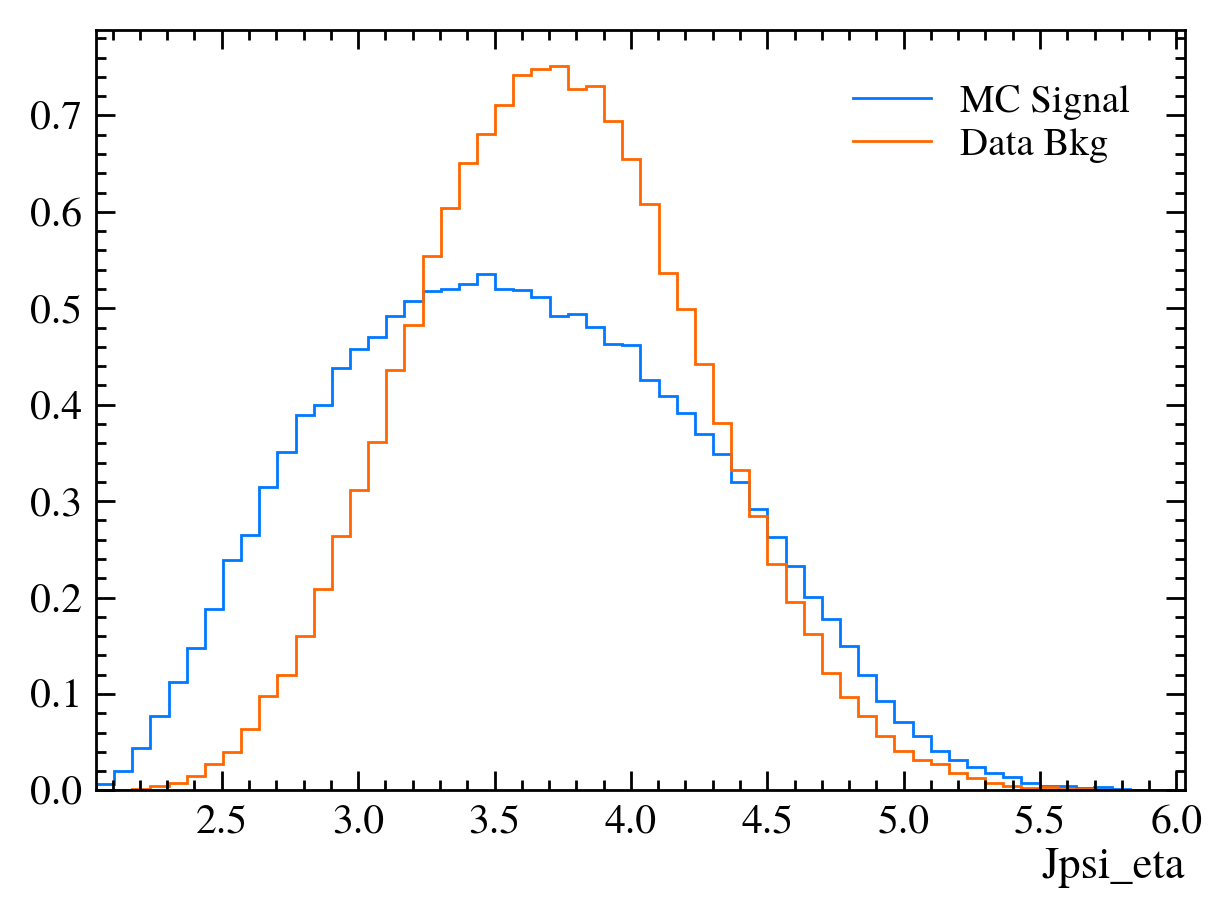

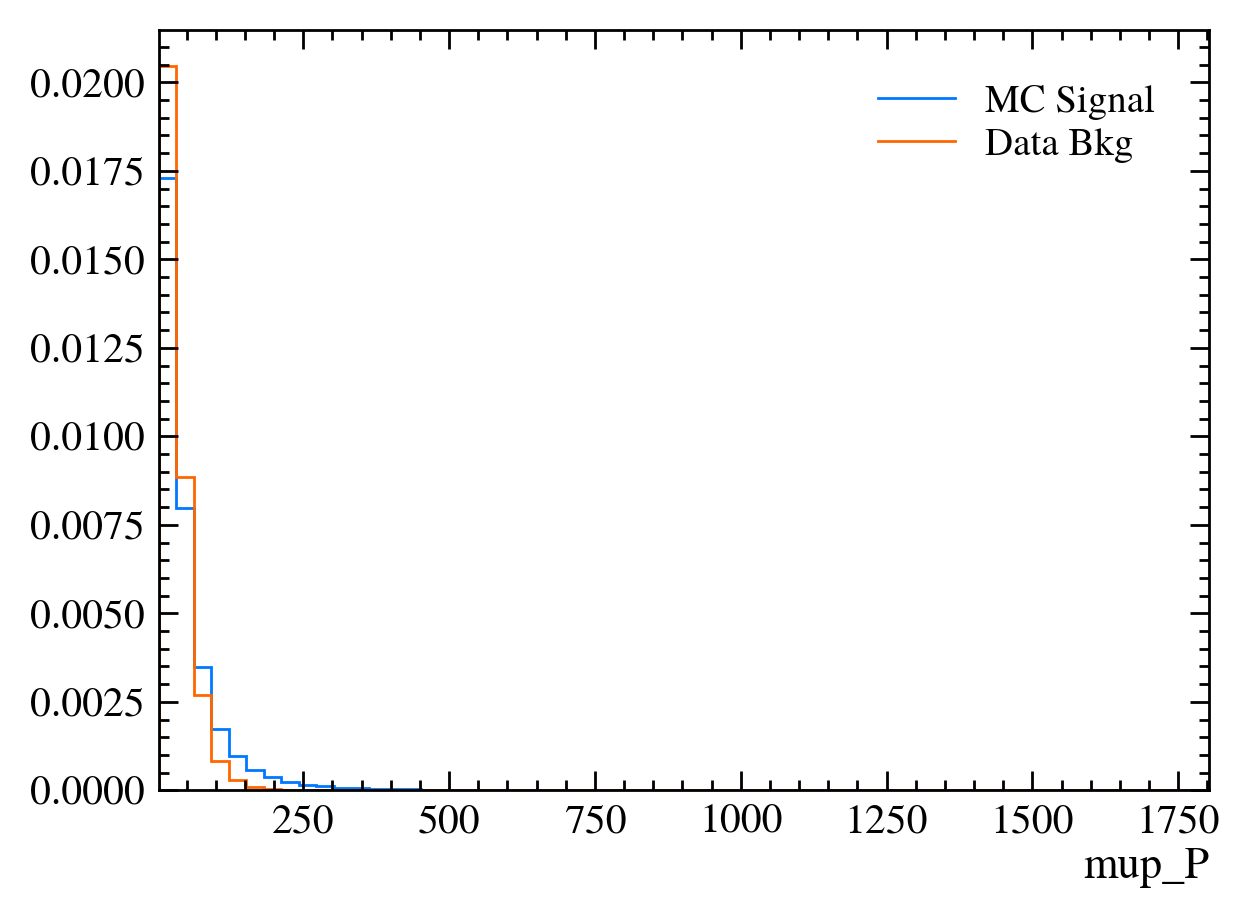

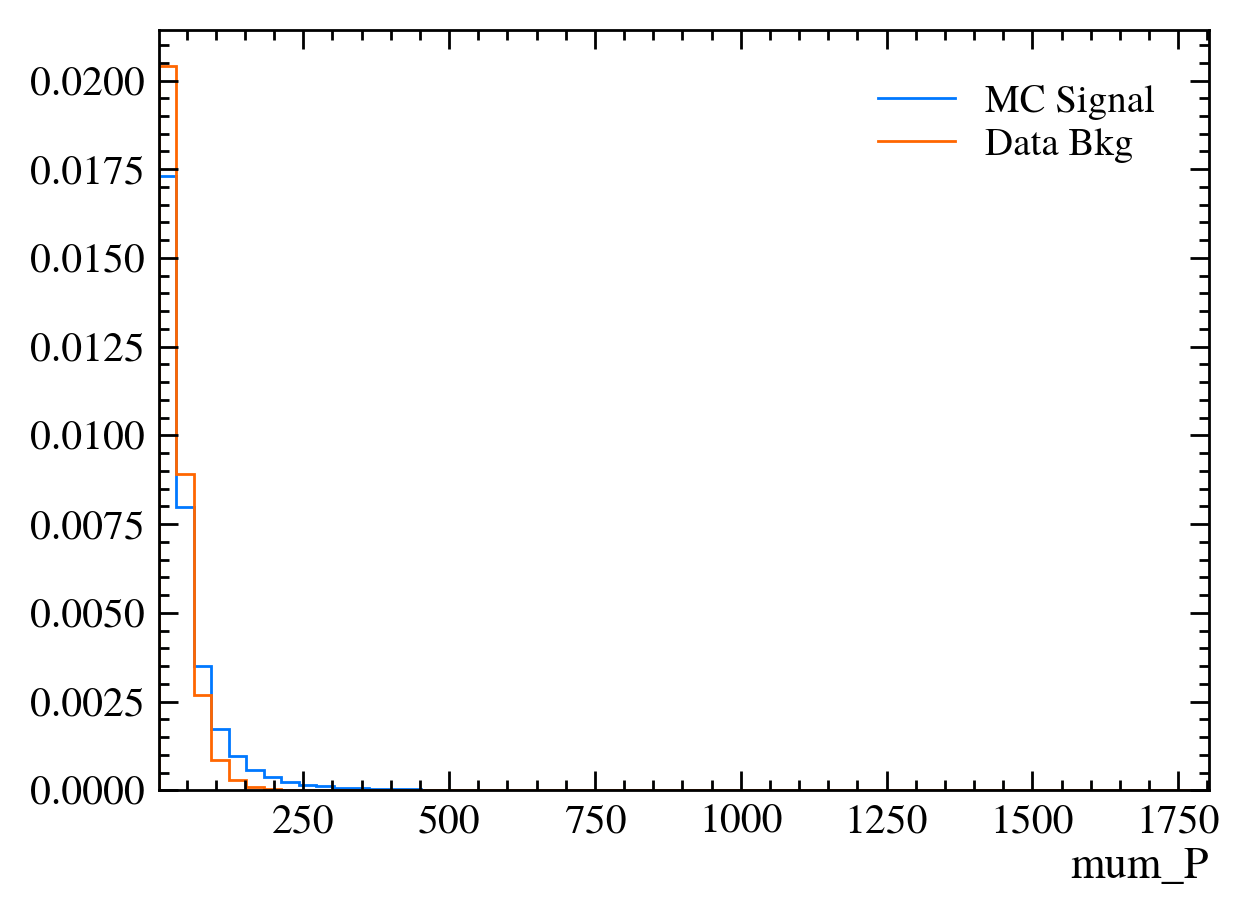

In [24]:
for var in data_df.columns:
    plt.figure()  # creates a new figure
    plot_comparision(var, mc_df, bkg_df)

Things to note:

 - This doesn't work for the $J/\psi$ mass variable: We can only rely on this method if the variable is independent of the mass. Fortunately we often want to do this as if a variable is heavily dependent on mass it can shape our distributions and can make it hard to know what is signal and what is background.
 - Muon mass is a fixed value for all muons: In this sample we have assumed the PDG value of the muon mass to allow us to calculate the energy component using only the information from the tracking detectors. This is often more precise than using calorimeters to measure $P_E$.
 - We got a warning about `More than 20 figures have been opened.`: Opening plots uses memory so if you open too many at the same time your scripts can be become slow or even crash. In this case we can ignore it as we only produce 30 plots but be careful if you ever make thousands of plots.
 - Pseudorapidity (eta) only goes between about 1 and 6: This dataset is supposed to look vaguely like LHCb data where the detector only covers that region.

**Exercise:** Look at the variables above and try to get a clean $J/\psi$ mass peak. Use the significance function to see how well you do.

**Aside:** We will want to use some of the variables and dataframes in the next lesson. In order to do this we will *store* them in this session and reload them in the next lesson.

In [25]:
%store bkg_df
%store mc_df
%store data_df

Stored 'bkg_df' (DataFrame)


Stored 'mc_df' (DataFrame)


Stored 'data_df' (DataFrame)
